<a name="top"> <h1>00.Data Reading and Preparation</h1> <a>

<p>Geospatial Analysis of the 2023 Earthquakes in Turkey<br />
<strong>Master Thesis</strong><br />
<strong>Master of Data Science</strong></p>


<p style="text-align:right">Gozde Yazganoglu (<em>gozde.yazganoglu@cunef.edu</em>)</p>

<a class="anchor" id="0.1"></a>

## Table of Contents

1. [Introduction](#1)
1. [Importing libraries](#2)
1. [Data Collection Prosses](#3)
1. [Areas of Interest](#4)
1. [Anciliary Information](#5)
1. [Saving data for other notebooks](#6)
1. [Saving data for other notebooks](#6)
1. [Saving data for other notebooks](#6)

## 1. Introduction <a class="anchor" id="1"></a>

[Back to Table of Contents](#0.1)

On 6 February 2023, a devastating Mw 7.8 earthquake hit southern and central Turkiye and northern and western Syria, followed by a Mw 7.7 earthquake. These were the largest seismic events in Turkiye since the 1939 Erzincan earthquake and among the strongest ever recorded in the Levant. The tremors were felt as far as Egypt and the Black Sea coast of Turkiye, with over 30,000 aftershocks recorded in the following three months.

The quakes resulted in widespread damage across an area of about 350,000 km2, affecting approximately 16 percent of Turkiye's population or an estimated 14 million people. About 1.5 million people were rendered homeless according to United Nations development experts.

The confirmed death toll was 59,259, with 50,783 deaths in Turkiye and 8,476 in Syria, making it the deadliest natural disaster in Turkiye's modern history and the deadliest in present-day Syria since the 1822 Aleppo earthquake. These were also the deadliest worldwide since the 2010 Haiti earthquake and the fifth-deadliest of the 21st century. The damage was estimated at US$104 billion in Turkiye and US$14.8 billion in Syria, ranking them as the fourth-costliest earthquakes on record.

The rescue and relief efforts were significantly hampered by damaged roads, winter storms, and communication disruptions. Despite the challenges, a rescue force of 60,000, 5,000 health workers, and 30,000 volunteers were deployed. In response to Turkiye's call for international assistance, more than 141,000 people from 94 countries joined the rescue effort.

Source : https://en.wikipedia.org/wiki/2023_Turkey%E2%80%93Syria_earthquake 

The economic losses have necessitated reconstruction or reinforcement of the affected area. It's crucial for businesses and political leaders to remember that this reconstruction involves a societal aspect - the city must be rebuilt in accordance with its specific economic and societal necessities. Moreover, as the hazard remains persistent, we must factor in existing risks, which could potentially open up future business opportunities. Hence, this issue should be given significant business consideration. Consequently, in this study, I have opted to investigate the condition of the buildings, facilities, and roads within the region.

In this notebook we are going to examine the dataset Copernicus EU Disaster data from satelites. We are taking the data from kaggle. Dataset has several information and it is not unitary for all locations. because of this reason, instead of examining this data set, we are going to check individually in locations and later we are going to merge all in a big data set.
Source : https://www.kaggle.com/datasets/brsdincer/feb-06-23earthquake-turkey-citiesvectors
Main Source : https://emergency.copernicus.eu/mapping/download/201003/Report_EMSR648_Earthquake_T%C3%BCrkiye_20230213.pdf?redirect=list-of-components/EMSR648/GRADING/ALL 


To have more information we are also going to take information devived from Turkstat databank (variables as popiulation, income, house sales...etc) and we will use AFAD data about 
Source: https://www.kaggle.com/datasets/ardaorcun/turkey-6-february-disaster-and-related-datas

Main Sources:
For earthquakes: https://deprem.afad.gov.tr/event-catalog
For any data about population and economic numbers: https://www.tuik.gov.tr/

Finally we also used also general fault information to understand the relationship of aproximity to the dangerous zones.

https://atag.itu.edu.tr/v4/?p=135




## 2. Importing libraries <a class="anchor" id="2"></a>

[Back to Table of Contents](#0.1)

In this notebook we are using new_geo_env.yaml. In order to run local this file should be installed.

We will use some functions from aux_func that is also in this repository.Below we import also the necessary ones.


In this notebook the dataset of our interest will be constructed in detailed operations.For this we need pandas/geopandas to manipulate geodata.


In [3]:

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import fiona
import os
import contextily as ctx
import pickle
import numpy as np
from shapely.ops import nearest_points
from sklearn.neighbors import BallTree
from aux_func import save_data, add_nearest_distance, plot_and_show_last


## 3. Data  Collection Process <a class="anchor" id="3"></a>

[Back to Table of Contents](#0.1)

In this notebook we are opening city vectors of the Copernicus disaster data. Data consist of several datasets and not unitary for all cities. For this reason instead of reading them in a on a fuction we are reading them individually. Below it is explaied which are the information we have in this dataset:

 * AncilliaryCrisisInfo : Locations of emergency meeting points
 * AreaofInterest : The unit ( city or province ) we are checking in this dataset.
 * Buildup : Buildings that we have the damage information.
 * Facilities : Facility buildings in the area
 * Hydrography : Water sources
 * Physiography : This datasets are consist of equal counter lines for the same level of height.
 * Thansportation : Roads in the area of interest. We also have damage information about roads.



Our target data of interest is the level of damage. Building, Facilities and Transportation items have this info and these datasets have more or less the same variables whis allows to be concataneted.
Area of interest information is necessary to differentiate and check whether there are different effects in different areas.

Elevation level, aproximity to the water are other geographic properties that might be interesting in this study. These factors has affect on quality of the zone. Most of the studies show that hard zones keep the building more strong. Meantime, we keep in to account that zone properties can differ in different places for the same building as well.

Another interesting datasets we observ in this data group is AncilliaryCrisisInfo data. If a zone is expecting a danger, or in case of other emergencies, exterior meeting points are very important. These zones can provide temporary shelter till danger is gone. It can be an important variable to define dangerous zones.  

For every region some socioeconomic data of interest is gathered from TURKSTAT website, geographic infotmation system. These variables might be useful in the results to understand business opportunties.

Source: https://cip.tuik.gov.tr/

### 3.2 Area of Interests at a glance <a class="anchor" id="4"></a>

[Back to Table of Contents](#0.1)

    
     1.Adiyaman: 

     As in the other cities and provinces we are going to have a look, province of Adiyaman is located in the southeast of Anatolia region and were highly effected/damaged by the earthquakes in february.

https://en.wikipedia.org/wiki/Ad%C4%B1yaman

In [5]:
#paths
# ancillary data for Adiyaman
path_adiyaman_anc = '../data/vectors/ADIYAMAN/M1_V1/EMSR648_AOI02_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI02_GRA_MONIT01_ancillaryCrisisInfoA_r1_v1.shp'
path_adiyaman_anc2 = '../data/vectors/ADIYAMAN/M1_V1/EMSR648_AOI02_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI02_GRA_MONIT01_ancillaryCrisisInfoP_r1_v1.shp'
# area of interest in Polygon
path_adiyaman_area = '../data/vectors/ADIYAMAN/M1_V1/EMSR648_AOI02_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI02_GRA_MONIT01_areaOfInterestA_r1_v1.shp'
# Water resources
path_adiyaman_hydro= '../data/vectors/ADIYAMAN/M1_V1/EMSR648_AOI02_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI02_GRA_MONIT01_hydrographyL_r1_v1.shp'

#Counterlines data
path_adiyaman_phisio= '../data/vectors/ADIYAMAN/M1_V1/EMSR648_AOI02_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI02_GRA_MONIT01_physiographyL_r1_v1.shp'
#data for transportation
path_adiyaman_transportation= '../data/vectors/ADIYAMAN/M1_V1/EMSR648_AOI02_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI02_GRA_MONIT01_transportationL_r1_v1.shp'

# facilities in the region
path_adiyaman_f = '../data/vectors/ADIYAMAN/M1_V1/EMSR648_AOI02_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI02_GRA_MONIT01_facilitiesA_r1_v1.shp'

#buildings in the region
path_adiyaman_b = '../data/vectors/ADIYAMAN/M1_V1/EMSR648_AOI02_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI02_GRA_MONIT01_builtUpA_r1_v1.shp'                 

# merging datasets of the facilities, buildings and transportation for Adiyaman
data_built= pd.concat ([gpd.read_file(path_adiyaman_b),gpd.read_file(path_adiyaman_b), gpd.read_file(path_adiyaman_transportation)])


#merging building dataset with area of interest so that we can kee this information in the data as well. Spatial joint is used for this purpose. Normal merge is not working for geopandas dataframes.
data_adiyaman = data_built.sjoin(gpd.read_file(path_adiyaman_area), how='inner', op='within')


/home/lapita/anaconda3/envs/tfm_graph/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
#adding population of last year and income in USD 
data_adiyaman['population'], data_adiyaman['income'] = 316140, 4092
#total and second hand sales in the municipality in the last five years
data_adiyaman['total_sales'], data_adiyaman['second_sales'] =  40087 ,20574
# percentage of accecing clean city water in the province
data_adiyaman['water_access']= 0.98
#electric consumption of per capita
data_adiyaman['elec_cons']= 2060
#number of buildings permited
data_adiyaman['building_perm']= 810
#m2 of the land permited for construction
data_adiyaman['land_permited'] = 695718
#labour force participation and unemployment rate in the province
data_adiyaman['labour_fource'] = 50
data_adiyaman['unemployment'] = 10.1

#agricultural area in decares
data_adiyaman['agricultural'] = 2336012
#expected lifetinme

data_adiyaman['life_time'] = 79.7
#number of hospitals and beds in the province per 100000 people
data_adiyaman['hb_per100000']= 222
#fertility rate in the province
data_adiyaman['fertility']= 2.36
#average household size
data_adiyaman['hh_size']= 4


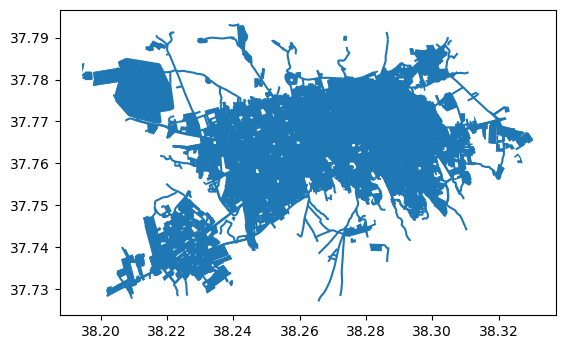

,obj_type,name,info,damage_gra,det_method,notation,or_src_id,dmg_src_id,cd_value,real,...,elec_cons,building_perm,land_permited,labour_fource,unemployment,agricultural,life_time,hb_per100000,fertility,hh_size
3758,"211-Highways, Streets and Roads",Haydar Efendi Caddesi,21121-Secondary Road,Damaged,Photo-interpretation,Not Applicable,994,3,Not Applicable,NaN,...,2060,810,695718,50,10.1,2336012,79.7,222,2.36,4
3759,"211-Highways, Streets and Roads",Kara Musa Caddesi,21122-Local Road,Damaged,Photo-interpretation,Not Applicable,994,3,Not Applicable,NaN,...,2060,810,695718,50,10.1,2336012,79.7,222,2.36,4
3760,"211-Highways, Streets and Roads",Unknown,21122-Local Road,No visible damage,Photo-interpretation,Not Applicable,994,3,Not Applicable,NaN,...,2060,810,695718,50,10.1,2336012,79.7,222,2.36,4
3761,"211-Highways, Streets and Roads",Unknown,21122-Local Road,Damaged,Photo-interpretation,Not Applicable,994,3,Not Applicable,NaN,...,2060,810,695718,50,10.1,2336012,79.7,222,2.36,4
3762,"211-Highways, Streets and Roads",Unknown,21122-Local Road,No visible damage,Photo-interpretation,Not Applicable,994,3,Not Applicable,NaN,...,2060,810,695718,50,10.1,2336012,79.7,222,2.36,4


In [7]:

#ploting the geometry of the data
plot_and_show_last(data_adiyaman)

    2. Afsin:

Afsin is a municipality located within the province of Kahramanmaras. The provided dataset, however, lacks ancillary details, facilities and doesn't include information about contour lines either. 

In a similar vein, extra data is manually extracted and incorporated into the dataset.

Info: https://en.wikipedia.org/wiki/Af%C5%9Fin


In [8]:

# building data
path_afsin = '../data/vectors/AFSIN/V1/EMSR648_AOI19_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI19_GRA_PRODUCT_builtUpP_r1_v1.shp'
# transportation data for AFSIN
path_afsin_transportation = '../data/vectors/AFSIN/V1/EMSR648_AOI19_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI19_GRA_PRODUCT_transportationL_r1_v1.shp'

# area of interest
path_afsin_area = '../data/vectors/AFSIN/V1/EMSR648_AOI19_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI19_GRA_PRODUCT_areaOfInterestA_r1_v1.shp'

#merging data for AFSIN
data_afsin = pd.concat([gpd.read_file(path_afsin),gpd.read_file(path_afsin_transportation)]).sjoin(gpd.read_file(path_afsin_area), how='inner', op='within')

# hydrography data for AFSIN
path_afsin_hidro = '../data/vectors/AFSIN/V1/EMSR648_AOI19_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI19_GRA_PRODUCT_hydrographyL_r1_v1.shp'



/home/lapita/anaconda3/envs/tfm_graph/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
#adding population of last year and income in USD
data_afsin['population'], data_afsin['income'] = 316140, 5997
#total and second hand sales in the municipality in the last five years
data_afsin['total_sales'], data_afsin['second_sales'] =  8762, 3300

# percentage of accecing clean city water in the province
data_afsin['water_access']= 0.95
#electric consumption of per capita
data_afsin['elec_cons']= 4343
#number of buildings permited
data_afsin['building_perm']= 1528
#m2 of the land permited for construction in province
data_afsin['land_permited'] = 2222311
#labour force participation and unemployment rate in the province
data_afsin['labour_fource'] = 48.1
data_afsin['unemployment'] = 17.1

#agricultural area in decares
data_afsin['agricultural'] = 3535085
#expected lifetinme
data_afsin['life_time'] = 79.2
#number of hospitals and beds in the province per 100000 people
data_afsin['hb_per100000']= 256
#fertility rate in the province
data_afsin['fertility']= 1.99
#average household size
data_afsin['hh_size']= 3.68

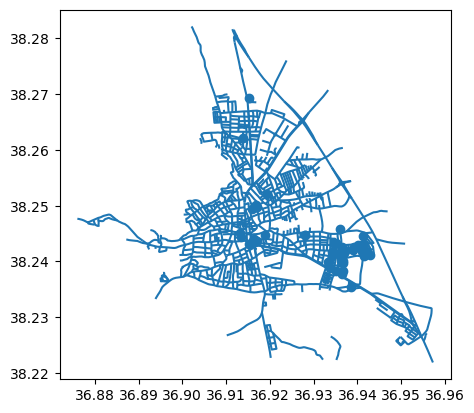

,obj_type,name,info,damage_gra,det_method,notation,or_src_id,dmg_src_id,cd_value,geometry,...,elec_cons,building_perm,land_permited,labour_fource,unemployment,agricultural,life_time,hb_per100000,fertility,hh_size
656,"211-Highways, Streets and Roads",Metehan Sokak,21122-Local Road,No visible damage,Photo-interpretation,Not Applicable,994,2,Not Applicable,"LINESTRING (36.91579 38.24962, 36.91528 38.249...",...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68
657,"211-Highways, Streets and Roads",Metehan Sokak,21122-Local Road,No visible damage,Photo-interpretation,Not Applicable,994,2,Not Applicable,"LINESTRING (36.91852 38.25060, 36.91756 38.250...",...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68
658,"211-Highways, Streets and Roads",Unknown,21122-Local Road,No visible damage,Photo-interpretation,Not Applicable,994,2,Not Applicable,"LINESTRING (36.92819 38.24502, 36.92818 38.24522)",...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68
659,"211-Highways, Streets and Roads",Unknown,21122-Local Road,Possibly damaged,Photo-interpretation,Not Applicable,994,2,Not Applicable,"LINESTRING (36.92821 38.24451, 36.92819 38.24502)",...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68
660,"211-Highways, Streets and Roads",Metehan Sokak,21122-Local Road,No visible damage,Photo-interpretation,Not Applicable,994,2,Not Applicable,"LINESTRING (36.91618 38.24974, 36.91610 38.249...",...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68


In [10]:
#to see representation of the data in map 
plot_and_show_last(data_afsin)

    3. Antakya:

Antakya is the large municipal center of Hatay province close to Syrian border. In the area lives people with different etnicities and historically an inportant center for many religions. With the buildings that people lived many historical monuments reported to be destroyed.

Info: https://en.wikipedia.org/wiki/Antakya 



In [11]:
#ANTAKYA DATA

#Building dataset

path_antakya = '../data/vectors/ANTAKYA/M1_V2/EMSR648_AOI11_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI11_GRA_MONIT01_builtUpA_r1_v2.shp'

#ancilary data
path_antakya_anc1 = '../data/vectors/ANTAKYA/M1_V2/EMSR648_AOI11_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI11_GRA_MONIT01_ancillaryCrisisInfoA_r1_v2.shp'
path_antakya_anc2 = '../data/vectors/ANTAKYA/M1_V2/EMSR648_AOI11_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI11_GRA_MONIT01_ancillaryCrisisInfoP_r1_v2.shp'

#water information
path_antakya_hidro = '../data/vectors/ANTAKYA/M1_V2/EMSR648_AOI11_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI11_GRA_MONIT01_hydrographyL_r1_v2.shp'

#transportation
path_antakya_transportation = '../data/vectors/ANTAKYA/M1_V2/EMSR648_AOI11_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI11_GRA_MONIT01_transportationL_r1_v2.shp'
#counter lines
path_antakya_phisio = '../data/vectors/ANTAKYA/M1_V2/EMSR648_AOI11_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI11_GRA_MONIT01_physiographyL_r1_v2.shp'

#area of interest
path_antakya_area = '../data/vectors/ANTAKYA/M1_V2/EMSR648_AOI11_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI11_GRA_MONIT01_areaOfInterestA_r1_v2.shp'


#merging data set and joining spatially witht the area of interest using the within operation
data_antakya = pd.concat([gpd.read_file(path_antakya),gpd.read_file(path_antakya_transportation)]).sjoin(gpd.read_file(path_antakya_area), how='inner', op='within')


/home/lapita/anaconda3/envs/tfm_graph/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
#Adding Additional statistical data for Antakya

#adding population of last year and income in USD
data_antakya['population'], data_antakya['income'] =  399045, 6785
#total and second hand sales in the municipality in the last five years
data_antakya['total_sales'], data_antakya['second_sales'] =  39858, 24992

# percentage of accecing clean city water in the province
data_antakya['water_access']= .99
#electric consumption of per capita
data_antakya['elec_cons']= 3984
#number of buildings permited
data_antakya['building_perm']= 1763
#m2 of the land permited for construction
data_antakya['land_permited'] =  2133640
#labour force participation and unemployment rate in the province
data_antakya['labour_fource'] = 48.1
data_antakya['unemployment'] = 17.1
#agricultural area in decares
data_antakya['agricultural'] = 353508523
#expected lifetinme
data_antakya['life_time'] = 77.9
#number of hospitals and beds in the province per 100000 people
data_antakya['hb_per100000']= 266
#fertility rate in the province
data_antakya['fertility']= 2.41
#average household size
data_antakya['hh_size']= 3.65

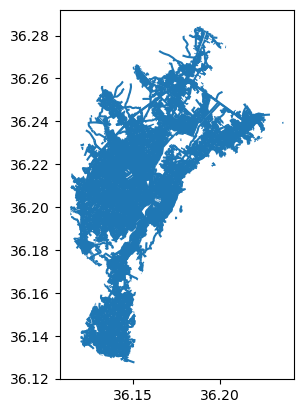

,obj_type,name,info,damage_gra,det_method,notation,or_src_id,dmg_src_id,cd_value,real,...,elec_cons,building_perm,land_permited,labour_fource,unemployment,agricultural,life_time,hb_per100000,fertility,hh_size
4608,"211-Highways, Streets and Roads",Unknown,21122-Local Road,Destroyed,Photo-interpretation,Not Applicable,994,2,Not Applicable,NaN,...,3984,1763,2133640,48.1,17.1,353508523,77.9,266,2.41,3.65
4609,"211-Highways, Streets and Roads",Unknown,21122-Local Road,No visible damage,Photo-interpretation,Not Applicable,994,2,Not Applicable,NaN,...,3984,1763,2133640,48.1,17.1,353508523,77.9,266,2.41,3.65
4610,"211-Highways, Streets and Roads",Adnan Menderes Caddesi,21121-Secondary Road,Destroyed,Photo-interpretation,Not Applicable,994,2,Not Applicable,NaN,...,3984,1763,2133640,48.1,17.1,353508523,77.9,266,2.41,3.65
4611,"211-Highways, Streets and Roads",KaraoÄlanoÄlu Caddesi,21122-Local Road,Damaged,Photo-interpretation,Not Applicable,994,2,Not Applicable,NaN,...,3984,1763,2133640,48.1,17.1,353508523,77.9,266,2.41,3.65
4612,"211-Highways, Streets and Roads",KaraoÄlanoÄlu Caddesi,21122-Local Road,No visible damage,Photo-interpretation,Not Applicable,994,2,Not Applicable,NaN,...,3984,1763,2133640,48.1,17.1,353508523,77.9,266,2.41,3.65


In [13]:
#representation of the data Antakya
plot_and_show_last(data_antakya)

    4. Bahce:

Bahce is a small town located in the Osmaniye Province of Southern Turkey. Known for its rich agricultural practices, Bahce is surrounded by expansive fields and farmlands. The region is part of the Çukurova, a large and historically significant agricultural region in Turkey.

Info: https://en.wikipedia.org/wiki/Bah%C3%A7e,_Osmaniye

In [14]:

#path for buildings dataset
path_bahce_b = '../data/vectors/BAHCE/M1_V1/EMSR648_AOI15_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI15_GRA_MONIT01_builtUpP_r1_v1.shp'

#path for facilities dataset
path_bahce_f = '../data/vectors/BAHCE/M1_V1/EMSR648_AOI15_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI15_GRA_MONIT01_facilitiesL_r1_v1.shp'

#path for ancillary dataset
path_bahce_anc1 = '../data/vectors/BAHCE/M1_V1/EMSR648_AOI15_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI15_GRA_MONIT01_ancillaryCrisisInfoA_r1_v1.shp'

#area of interest
path_bahce_area = '../data/vectors/BAHCE/M1_V1/EMSR648_AOI15_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI15_GRA_MONIT01_areaOfInterestA_r1_v1.shp'

#path for transportation dataset
path_bahce_transportation = '../data/vectors/BAHCE/M1_V1/EMSR648_AOI15_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI15_GRA_MONIT01_transportationL_r1_v1.shp'

#path for counter elevatio  dataset
path_bahce_phisio = '../data/vectors/BAHCE/M1_V1/EMSR648_AOI15_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI15_GRA_MONIT01_physiographyL_r1_v1.shp'

#path for water resources
path_bahce_hidro = '../data/vectors/BAHCE/M1_V1/EMSR648_AOI15_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI15_GRA_MONIT01_hydrographyL_r1_v1.shp'

data_bahce = (pd.concat([gpd.read_file(path_bahce_b),gpd.read_file(path_bahce_f),gpd.read_file(path_bahce_transportation)])
.sjoin(gpd.read_file(path_bahce_area), how='inner', op='within'))



/home/lapita/anaconda3/envs/tfm_graph/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
#Adding additional information od Bahce data
#adding population of last year and income in USD
data_bahce['population'], data_bahce['income'] =  22904, 6256
#total and second hand sales in the municipality in the last five years
data_bahce['total_sales'], data_bahce['second_sales'] =  1588, 664

# percentage of accecing clean city water in the province
data_bahce['water_access']= 0.95
#electric consumption of per capita
data_bahce['elec_cons']= 7413

#number of buildings permited
data_bahce['building_perm']= 583
#m2 of the land permited for construction
data_bahce['land_permited'] =  782505
#labour force participation and unemployment rate in the province
data_bahce['labour_fource'] = 48.1
data_bahce['unemployment'] = 17.1
#agricultural area in decares
data_bahce['agricultural'] = 1233061
#expected lifetinme
data_bahce['life_time'] = 78
#number of hospitals and beds in the province per 100000 people
data_bahce['hb_per100000']= 246
#fertility rate in the province
data_bahce['fertility']= 1.92
#average household size
data_bahce['hh_size']= 3.46

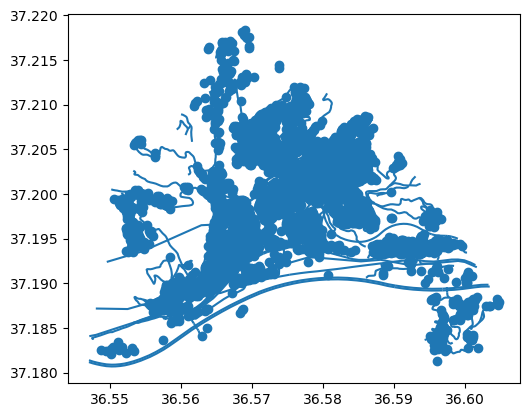

,obj_type,name,info,damage_gra,det_method,notation,or_src_id,dmg_src_id,cd_value,geometry,...,elec_cons,building_perm,land_permited,labour_fource,unemployment,agricultural,life_time,hb_per100000,fertility,hh_size
422,"211-Highways, Streets and Roads",Unknown,21122-Local Road,No visible damage,Photo-interpretation,Not Applicable,1,2,Not Applicable,"LINESTRING (36.58247 37.19322, 36.58273 37.193...",...,7413,583,782505,48.1,17.1,1233061,78,246,1.92,3.46
423,"211-Highways, Streets and Roads",Unknown,21122-Local Road,No visible damage,Photo-interpretation,Not Applicable,1,2,Not Applicable,"LINESTRING (36.56154 37.18589, 36.56172 37.186...",...,7413,583,782505,48.1,17.1,1233061,78,246,1.92,3.46
424,"211-Highways, Streets and Roads",Gaziantep-Osmaniye yolu,21120-Primary Road,No visible damage,Photo-interpretation,Not Applicable,1,2,Not Applicable,"LINESTRING (36.56212 37.18719, 36.56186 37.187...",...,7413,583,782505,48.1,17.1,1233061,78,246,1.92,3.46
425,"211-Highways, Streets and Roads",Unknown,21122-Local Road,No visible damage,Photo-interpretation,Not Applicable,1,2,Not Applicable,"LINESTRING (36.56022 37.19204, 36.56045 37.192...",...,7413,583,782505,48.1,17.1,1233061,78,246,1.92,3.46
426,"211-Highways, Streets and Roads",Unknown,21122-Local Road,No visible damage,Photo-interpretation,Not Applicable,1,2,Not Applicable,"LINESTRING (36.55771 37.18600, 36.55797 37.186...",...,7413,583,782505,48.1,17.1,1233061,78,246,1.92,3.46


In [16]:
#basic representations of data
plot_and_show_last(data_bahce)

    5. Diyarbakir:

Diyarbakir is one of the largest cities in southeastern Turkey and is rich in historical and cultural significance. Known for its impressive, black basalt city walls - one of the most extensive fortification systems in the world - the city has a history dating back thousands of years with influences from many empires, including the Romans, Byzantines, and Ottomans.

In [17]:
#Diyarbakir data

#buildings
path_diyarbakir = '../data/vectors/DIYARBAKIR/M1_V1/EMSR648_AOI03_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI03_GRA_MONIT01_builtUpA_r1_v1.shp'
#ancillary info
path_diyarbakir_anc = '../data/vectors/DIYARBAKIR/M1_V1/EMSR648_AOI03_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI03_GRA_MONIT01_ancillaryCrisisInfoP_r1_v1.shp'

#area of interest
path_diyarbakir_area = '../data/vectors/DIYARBAKIR/M1_V1/EMSR648_AOI03_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI03_GRA_MONIT01_areaOfInterestA_r1_v1.shp'

#diyarbakir has several transportation datasets for the same area
path_diyarbakir_transportation1 = '../data/vectors/DIYARBAKIR/M1_V1/EMSR648_AOI03_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI03_GRA_MONIT01_transportationL_r1_v1.shp'
path_diyarbakir_transportation2 = '../data/vectors/DIYARBAKIR/M1_V1/EMSR648_AOI03_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI03_GRA_MONIT01_transportationA_r1_v1.shp'

path_diyarbakir_transportation3 = '../data/vectors/DIYARBAKIR/M1_V1/EMSR648_AOI03_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI03_GRA_MONIT01_transportationP_r1_v1.shp'

#water resources

path_diyarbakir_hidro = '../data/vectors/DIYARBAKIR/M1_V1/EMSR648_AOI03_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI03_GRA_MONIT01_hydrographyA_r1_v1.shp'


#counter elevations
path_diyarbakir_phisio = '../data/vectors/DIYARBAKIR/M1_V1/EMSR648_AOI03_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI03_GRA_MONIT01_physiographyL_r1_v1.shp'

#merging buildings and transportation with area of interest
data_diyarbakir = (pd.concat([gpd.read_file(path_diyarbakir),gpd.read_file(path_diyarbakir_transportation1),gpd.read_file(path_diyarbakir_transportation2),gpd.read_file(path_diyarbakir_transportation3)])
.sjoin(gpd.read_file(path_diyarbakir_area), how='inner', op='within'))


dt= gpd.read_file(path_diyarbakir)

dt


/home/lapita/anaconda3/envs/tfm_graph/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


,obj_type,name,info,damage_gra,det_method,notation,or_src_id,dmg_src_id,cd_value,real,geometry
0,11-Residential Buildings,Unknown,997-Not Applicable,Damaged,Photo-interpretation,Building block,994,3,Not Applicable,Not Applicable,"POLYGON ((40.18035 37.90188, 40.17963 37.90169..."
1,11-Residential Buildings,Unknown,997-Not Applicable,Possibly damaged,Photo-interpretation,Building block,994,3,Not Applicable,Not Applicable,"POLYGON ((40.22586 37.88913, 40.22606 37.88790..."
2,11-Residential Buildings,Unknown,997-Not Applicable,Possibly damaged,Photo-interpretation,Building block,994,3,Not Applicable,Not Applicable,"POLYGON ((40.22741 37.90586, 40.22719 37.90537..."
3,11-Residential Buildings,Unknown,997-Not Applicable,Damaged,Photo-interpretation,Building block,994,3,Not Applicable,Not Applicable,"POLYGON ((40.22356 37.90630, 40.22349 37.90629..."
4,11-Residential Buildings,Unknown,997-Not Applicable,Damaged,Photo-interpretation,Building block,994,3,Not Applicable,Not Applicable,"POLYGON ((40.22143 37.90500, 40.22142 37.90495..."
...,...,...,...,...,...,...,...,...,...,...,...
92,11-Residential Buildings,Unknown,997-Not Applicable,Possibly damaged,Photo-interpretation,Building block,994,3,Not Applicable,Not Applicable,"POLYGON ((40.22847 37.90942, 40.22832 37.90924..."
93,11-Residential Buildings,Unknown,997-Not Applicable,Possibly damaged,Photo-interpretation,Building block,994,4,Not Applicable,Not Applicable,"POLYGON ((40.23120 37.91553, 40.23023 37.91521..."
94,11-Residential Buildings,Unknown,997-Not Applicable,Destroyed,Photo-interpretation,Building block,4,4,Not Applicable,Not Applicable,"POLYGON ((40.22089 37.91718, 40.22048 37.91753..."
95,11-Residential Buildings,Unknown,997-Not Applicable,Damaged,Photo-interpretation,Building block,4,4,Not Applicable,Not Applicable,"POLYGON ((40.23406 37.90828, 40.23316 37.90824..."


In [18]:
#adding population of last year and income in USD
data_diyarbakir['population'], data_diyarbakir['income'] =  1804880, 3893
#total and second hand sales in the municipality in the last five years
data_diyarbakir['total_sales'], data_diyarbakir['second_sales'] =  145244, 83985

# percentage of accecing clean city water in the province
data_diyarbakir['water_access']= 0.95
#electric consumption of per capita
data_diyarbakir['elec_cons']= 1631
#number of buildings permited
data_diyarbakir['building_perm']=  1336
#m2 of the land permited for construction
data_diyarbakir['land_permited'] =  1996910
#labour force participation and unemployment rate in the province
data_diyarbakir['labour_fource'] = 40.6
data_diyarbakir['unemployment'] = 15.00
#agricultural area in decares
data_diyarbakir['agricultural'] =  5735761
#expected lifetinme
data_diyarbakir['life_time'] = 78.9  
#number of hospitals and beds in the province per 100000 people
data_diyarbakir['hb_per100000']=  269
#fertility rate in the province
data_diyarbakir['fertility']=  2.54
#average household size
data_diyarbakir['hh_size']=  4.43

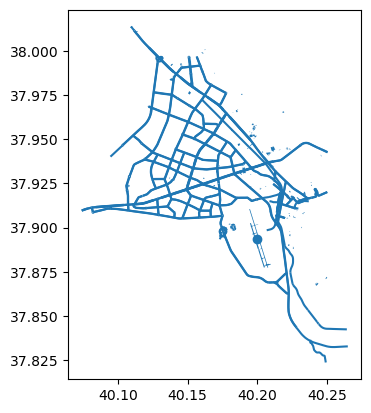

,obj_type,name,info,damage_gra,det_method,notation,or_src_id,dmg_src_id,cd_value,real,...,elec_cons,building_perm,land_permited,labour_fource,unemployment,agricultural,life_time,hb_per100000,fertility,hh_size
797,"211-Highways, Streets and Roads",Unknown,2111-Highways,No visible damage,Photo-interpretation,Not Applicable,994,2,Not Applicable,NaN,...,1631,1336,1996910,40.6,15.0,5735761,78.9,269,2.54,4.43
798,"211-Highways, Streets and Roads",DiyarbakÄ±r-ÅanlÄ±urfa yolu,2111-Highways,No visible damage,Photo-interpretation,Not Applicable,994,2,Not Applicable,NaN,...,1631,1336,1996910,40.6,15.0,5735761,78.9,269,2.54,4.43
799,"211-Highways, Streets and Roads",DiyarbakÄ±r-ÅanlÄ±urfa yolu,2111-Highways,No visible damage,Photo-interpretation,Not Applicable,994,2,Not Applicable,NaN,...,1631,1336,1996910,40.6,15.0,5735761,78.9,269,2.54,4.43
0,213-Airfield,Unknown,2130-Airfield runways,No visible damage,Photo-interpretation,Not Applicable,994,3,Not Applicable,NaN,...,1631,1336,1996910,40.6,15.0,5735761,78.9,269,2.54,4.43
0,213-Airfield,DiyarbakÄ±r HavalimanÄ±,2130-Airfield runways,No visible damage,Photo-interpretation,Not Applicable,1,3,Not Applicable,NaN,...,1631,1336,1996910,40.6,15.0,5735761,78.9,269,2.54,4.43


In [19]:
#Representation of data
plot_and_show_last(data_diyarbakir)

    6.Duzici : 

Düzici is a town and district of Osmaniye Province in the Mediterranean region of Turkey. As a relatively small district, it carries its own unique local charm. The area is primarily agricultural, with farming being a significant part of the local economy. Given its location in the Mediterranean region, Düzici enjoys a mild climate with hot, dry summers and warm, wet winters, which is conducive to growing a variety of crops. Despite its size, Düzici and its surrounding regions hold cultural and historical significance, being part of a country with a rich history dating back thousands of years.

In [20]:
#Duzici data

#buildings and facilities

path_duzici_b = '../data/vectors/DUZICI/M1_V1/EMSR648_AOI14_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI14_GRA_MONIT01_builtUpP_r1_v1.shp'
path_duzici_f = '../data/vectors/DUZICI/M1_V1/EMSR648_AOI14_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI14_GRA_MONIT01_facilitiesA_r1_v1.shp'

#area of interest
path_duzici_area = '../data/vectors/DUZICI/M1_V1/EMSR648_AOI14_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI14_GRA_MONIT01_areaOfInterestA_r1_v1.shp'

#ancillary data
path_duzici_anc1 = '../data/vectors/DUZICI/M1_V1/EMSR648_AOI14_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI14_GRA_MONIT01_ancillaryCrisisInfoA_r1_v1.shp'
path_duzici_anc2 = '../data/vectors/DUZICI/M1_V1/EMSR648_AOI14_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI14_GRA_MONIT01_ancillaryCrisisInfoP_r1_v1.shp'

#water bodies
path_duzici_hidro = '../data/vectors/DUZICI/M1_V1/EMSR648_AOI14_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI14_GRA_MONIT01_hydrographyL_r1_v1.shp'

# counter elevation lines
path_duzici_phisio = '../data/vectors/DUZICI/M1_V1/EMSR648_AOI14_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI14_GRA_MONIT01_physiographyL_r1_v1.shp'

#transportation
path_duzici_transportation = '../data/vectors/DUZICI/M1_V1/EMSR648_AOI14_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI14_GRA_MONIT01_transportationL_r1_v1.shp'

data_duzici = (pd.concat([gpd.read_file(path_duzici_b),gpd.read_file(path_duzici_f),gpd.read_file(path_duzici_transportation)])
               .sjoin(gpd.read_file(path_duzici_area), how='inner', op='within'))


/home/lapita/anaconda3/envs/tfm_graph/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [21]:
#adding population of last year and income in USD
data_duzici['population'], data_duzici['income'] = 85448, 6256
#total and second hand sales in the municipality in the last five years
data_duzici['total_sales'], data_duzici['second_sales'] =  6203, 2289

 # percentage of accecing clean city water in the province
data_duzici['water_access']= 0.95
#electric consumption of per capita
data_duzici['elec_cons']= 7413

#number of buildings permited
data_duzici['building_perm']= 583
#m2 of the land permited for construction
data_duzici['land_permited'] =  782505
#labour force participation and unemployment rate in the province
data_duzici['labour_fource'] = 48.1
data_duzici['unemployment'] = 17.1
#agricultural area in decares
data_duzici['agricultural'] = 1233061
#expected lifetinme
data_duzici['life_time'] = 78
#number of hospitals and beds in the province per 100000 people
data_duzici['hb_per100000']= 246
#fertility rate in the province
data_duzici['fertility']= 1.92
#average household size
data_duzici['hh_size']= 3.46


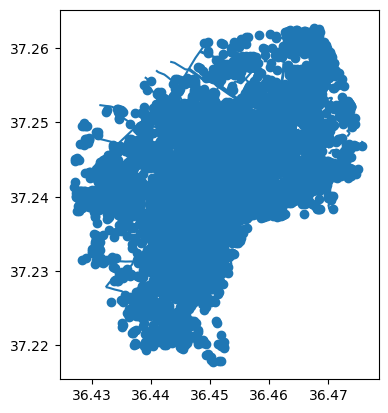

,obj_type,name,info,damage_gra,det_method,notation,or_src_id,dmg_src_id,cd_value,geometry,...,elec_cons,building_perm,land_permited,labour_fource,unemployment,agricultural,life_time,hb_per100000,fertility,hh_size
651,"211-Highways, Streets and Roads",Unknown,21122-Local Road,No visible damage,Photo-interpretation,Not Applicable,994,3,Not Applicable,"LINESTRING (36.45549 37.24211, 36.45482 37.242...",...,7413,583,782505,48.1,17.1,1233061,78,246,1.92,3.46
652,"211-Highways, Streets and Roads",Unknown,21122-Local Road,Damaged,Photo-interpretation,Not Applicable,994,3,Not Applicable,"LINESTRING (36.45076 37.24322, 36.45059 37.243...",...,7413,583,782505,48.1,17.1,1233061,78,246,1.92,3.46
653,"211-Highways, Streets and Roads",Unknown,21122-Local Road,No visible damage,Photo-interpretation,Not Applicable,994,3,Not Applicable,"LINESTRING (36.44144 37.23902, 36.44239 37.239...",...,7413,583,782505,48.1,17.1,1233061,78,246,1.92,3.46
654,"211-Highways, Streets and Roads",Unknown,21122-Local Road,Damaged,Photo-interpretation,Not Applicable,994,3,Not Applicable,"LINESTRING (36.44417 37.23865, 36.44424 37.23894)",...,7413,583,782505,48.1,17.1,1233061,78,246,1.92,3.46
655,"211-Highways, Streets and Roads",Unknown,21122-Local Road,Damaged,Photo-interpretation,Not Applicable,994,3,Not Applicable,"LINESTRING (36.44381 37.23897, 36.44424 37.23894)",...,7413,583,782505,48.1,17.1,1233061,78,246,1.92,3.46


In [22]:
# representativplot and head of the dataset
plot_and_show_last(data_duzici)

    7. Elbistan:

Elbistan is a district in Kahramanmaraş Province in southern Turkey, located in the eastern part of the Mediterranean region. It's the most populous district of the province and known primarily for its extensive coal reserves. The Elbistan area has the largest lignite (brown coal) deposit in Turkey, and there are major power plants in the district to utilize this resource.


In [23]:
#buildings and facilities
path_elbistan_b = '../data/vectors/ELBISTAN/M1_V1/EMSR648_AOI20_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI20_GRA_MONIT01_builtUpP_r1_v1.shp'
path_elbistan_f = '../data/vectors/ELBISTAN/M1_V1/EMSR648_AOI20_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI20_GRA_MONIT01_facilitiesA_r1_v1.shp'


#ancillary and area of interest

path_elbistan_anc = '../data/vectors/ELBISTAN/M1_V1/EMSR648_AOI20_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI20_GRA_MONIT01_ancillaryCrisisInfoP_r1_v1.shp'
path_elbistan_area = '../data/vectors/ELBISTAN/M1_V1/EMSR648_AOI20_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI20_GRA_MONIT01_areaOfInterestA_r1_v1.shp'


#watersources

path_elbistan_hidro = '../data/vectors/ELBISTAN/M1_V1/EMSR648_AOI20_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI20_GRA_MONIT01_hydrographyL_r1_v1.shp'

#physiography
path_elbistan_phisio = '../data/vectors/ELBISTAN/M1_V1/EMSR648_AOI20_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI20_GRA_MONIT01_physiographyL_r1_v1.shp'

path_elbistan_transportation = '../data/vectors/ELBISTAN/M1_V1/EMSR648_AOI20_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI20_GRA_MONIT01_transportationL_r1_v1.shp'

data_elbistan = (pd.concat([gpd.read_file(path_elbistan_b),gpd.read_file(path_elbistan_f),gpd.read_file(path_elbistan_transportation)])
                 .sjoin(gpd.read_file(path_elbistan_area), how='inner', op='within'))

/home/lapita/anaconda3/envs/tfm_graph/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [24]:
#adding population of last year and income in USD
data_elbistan['population'], data_elbistan['income'] =  77180,  5997
#total and second hand sales in the municipality in the last five years
data_elbistan['total_sales'], data_elbistan['second_sales'] =  18139, 10133

# percentage of accecing clean city water in the province
data_elbistan['water_access']= 0.95
#electric consumption of per capita
data_elbistan['elec_cons']= 4343
#number of buildings permited
data_elbistan['building_perm']= 1528
#m2 of the land permited for construction in province
data_elbistan['land_permited'] = 2222311
#labour force participation and unemployment rate in the province
data_elbistan['labour_fource'] = 48.1
data_elbistan['unemployment'] = 17.1

#agricultural area in decares
data_elbistan['agricultural'] = 3535085
#expected lifetinme
data_elbistan['life_time'] = 79.2
#number of hospitals and beds in the province per 100000 people
data_elbistan['hb_per100000']= 256
#fertility rate in the province
data_elbistan['fertility']= 1.99
#average household size
data_elbistan['hh_size']= 3.68

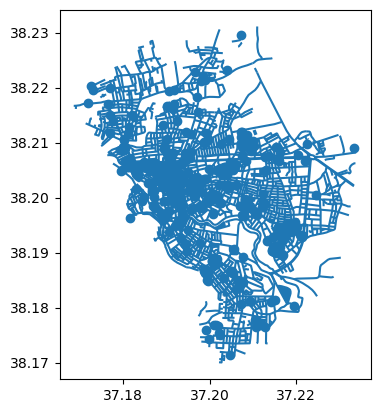

,obj_type,name,info,damage_gra,det_method,notation,or_src_id,dmg_src_id,cd_value,geometry,...,elec_cons,building_perm,land_permited,labour_fource,unemployment,agricultural,life_time,hb_per100000,fertility,hh_size
1246,"211-Highways, Streets and Roads",Malatya Caddesi,21122-Local Road,Damaged,Photo-interpretation,Not Applicable,994,4,Not Applicable,"LINESTRING (37.20261 38.20495, 37.20318 38.20512)",...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68
1247,"211-Highways, Streets and Roads",Unknown,21122-Local Road,Damaged,Photo-interpretation,Not Applicable,994,4,Not Applicable,"LINESTRING (37.20234 38.19968, 37.20197 38.199...",...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68
1248,"211-Highways, Streets and Roads",Unknown,21122-Local Road,Damaged,Photo-interpretation,Not Applicable,994,4,Not Applicable,"LINESTRING (37.20757 38.18418, 37.20751 38.184...",...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68
1249,"211-Highways, Streets and Roads",Unknown,21122-Local Road,Damaged,Photo-interpretation,Not Applicable,994,4,Not Applicable,"LINESTRING (37.20679 38.18439, 37.20687 38.18394)",...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68
1250,"211-Highways, Streets and Roads",Unknown,21122-Local Road,Damaged,Photo-interpretation,Not Applicable,994,4,Not Applicable,"LINESTRING (37.20687 38.18394, 37.20734 38.18397)",...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68


In [25]:
# basis representations:
plot_and_show_last(data_elbistan)

    8.Erdemoglu:

Adiyaman is a city in southeastern Turkey known for its historical and archaeological sites.In dataset, consist of buildings and transportation.

In [26]:
#data Erdemoglu

#Building dataset
path_erdemoglu = '../data/vectors/ERDEMOGLU/M1_V1/EMSR648_AOI12_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI12_GRA_MONIT01_builtUpP_r1_v1.shp'
#ancilarry dataset
path_erdemoglu_anc = '../data/vectors/ERDEMOGLU/M1_V1/EMSR648_AOI12_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI12_GRA_MONIT01_ancillaryCrisisInfoP_r1_v1.shp'
#area of interest
path_erdemoglu_area = '../data/vectors/ERDEMOGLU/M1_V1/EMSR648_AOI12_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI12_GRA_MONIT01_areaOfInterestA_r1_v1.shp'
# roads dataset
path_transportation = '../data/vectors/ERDEMOGLU/M1_V1/EMSR648_AOI12_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI12_GRA_MONIT01_transportationL_r1_v1.shp'
# water resources
path_erdemoglu_hidro = '../data/vectors/ERDEMOGLU/M1_V1/EMSR648_AOI12_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI12_GRA_MONIT01_hydrographyL_r1_v1.shp'

# counter elevation
path_erdemoglu_phisio = '../data/vectors/ERDEMOGLU/M1_V1/EMSR648_AOI12_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI12_GRA_MONIT01_physiographyL_r1_v1.shp'

#merging building and transportation and adding area of interest info to the dataset
data_erdemoglu = (pd.concat([gpd.read_file(path_erdemoglu),gpd.read_file(path_transportation)])
                  .sjoin(gpd.read_file(path_erdemoglu_area), how='inner', op='within'))




/home/lapita/anaconda3/envs/tfm_graph/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [27]:
#adding population of last year and income in USD
data_erdemoglu['population'], data_erdemoglu['income'] =  77180, 4092
#total and second hand sales in the municipality in the last five years
data_erdemoglu['total_sales'], data_erdemoglu['second_sales'] =  9675, 4098

# percentage of accecing clean city water in the province
data_erdemoglu['water_access']= 0.98
#electric consumption of per capita
data_erdemoglu['elec_cons']= 2060
#number of buildings permited
data_erdemoglu['building_perm']= 810
#m2 of the land permited for construction
data_erdemoglu['land_permited'] = 695718
#labour force participation and unemployment rate in the province
data_erdemoglu['labour_fource'] = 50
data_erdemoglu['unemployment'] = 10.1

#agricultural area in decares
data_erdemoglu['agricultural'] = 2336012
#expected lifetinme

data_erdemoglu['life_time'] = 79.7
#number of hospitals and beds in the province per 100000 people
data_erdemoglu['hb_per100000']= 222
#fertility rate in the province
data_erdemoglu['fertility']= 2.36
#average household size
data_erdemoglu['hh_size']= 4

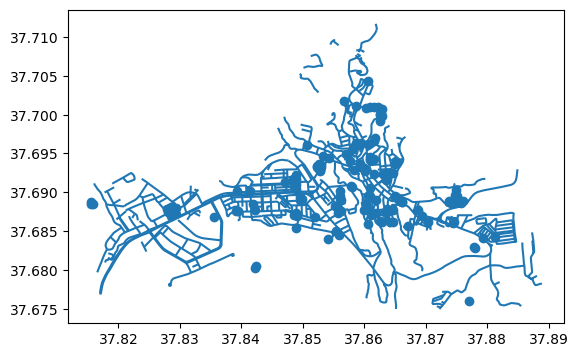

,obj_type,name,info,damage_gra,det_method,notation,or_src_id,dmg_src_id,cd_value,geometry,...,elec_cons,building_perm,land_permited,labour_fource,unemployment,agricultural,life_time,hb_per100000,fertility,hh_size
418,"211-Highways, Streets and Roads",Unknown,21124-Cart Track,No visible damage,Photo-interpretation,Not Applicable,994,2,Not Applicable,"LINESTRING (37.88181 37.67716, 37.88181 37.677...",...,2060,810,695718,50,10.1,2336012,79.7,222,2.36,4
419,"211-Highways, Streets and Roads",Unknown,21124-Cart Track,No visible damage,Photo-interpretation,Not Applicable,994,2,Not Applicable,"LINESTRING (37.86201 37.71086, 37.86204 37.710...",...,2060,810,695718,50,10.1,2336012,79.7,222,2.36,4
420,"211-Highways, Streets and Roads",Unknown,21124-Cart Track,No visible damage,Photo-interpretation,Not Applicable,994,2,Not Applicable,"LINESTRING (37.88474 37.68352, 37.88470 37.683...",...,2060,810,695718,50,10.1,2336012,79.7,222,2.36,4
421,"211-Highways, Streets and Roads",Unknown,21124-Cart Track,No visible damage,Photo-interpretation,Not Applicable,994,2,Not Applicable,"LINESTRING (37.86163 37.67942, 37.86130 37.679...",...,2060,810,695718,50,10.1,2336012,79.7,222,2.36,4
422,"211-Highways, Streets and Roads",Unknown,21124-Cart Track,No visible damage,Photo-interpretation,Not Applicable,994,2,Not Applicable,"LINESTRING (37.86329 37.67826, 37.86320 37.678...",...,2060,810,695718,50,10.1,2336012,79.7,222,2.36,4


In [28]:
# basic representations of the data

plot_and_show_last(data_erdemoglu)

    9.Gaziantep: 

Gaziantep, often simply referred to as Antep, is a city located in southeastern Turkey. It's one of the oldest continuously inhabited cities in the world, with a history dating back to the Hittite era. Gaziantep is renowned for its unique culinary traditions, especially its pistachio-based baklava, and its large, diverse collection of Roman mosaics housed in the Zeugma Mosaic Museum. Its vibrant bazaars, rich history, and cultural heritage make Gaziantep a fascinating destination for visitors.

Info: https://en.wikipedia.org/wiki/Gaziantep

Dataset includes building, facilities and transportation info.

In [29]:
# data for Gaziantep
#buildings
path_gaziantep_b = '../data/vectors/GAZIANTEP/M1_V1/EMSR648_AOI01_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI01_GRA_MONIT01_builtUpP_r1_v1.shp'
#facilities
path_gaziantep_f = '../data/vectors/GAZIANTEP/M1_V1/EMSR648_AOI01_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI01_GRA_MONIT01_facilitiesL_r1_v1.shp'
#area of interest in polygon
path_gaziantep_area = '../data/vectors/GAZIANTEP/M1_V1/EMSR648_AOI01_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI01_GRA_MONIT01_areaOfInterestA_r1_v1.shp'
# anciliary crisis info
path_gaziantep_anc = '../data/vectors/GAZIANTEP/M1_V1/EMSR648_AOI01_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI01_GRA_MONIT01_ancillaryCrisisInfoP_r1_v1.shp'
# Water resources
path_gaziantep_hidro = '../data/vectors/GAZIANTEP/M1_V1/EMSR648_AOI01_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI01_GRA_MONIT01_hydrographyL_r1_v1.shp'
# Transportation
path_gaziantep_transportation = '../data/vectors/GAZIANTEP/M1_V1/EMSR648_AOI01_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI01_GRA_MONIT01_transportationL_r1_v1.shp'
#Elevation countours
path_gaziantep_phisio = '../data/vectors/GAZIANTEP/M1_V1/EMSR648_AOI01_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI01_GRA_MONIT01_physiographyL_r1_v1.shp'

#merging buildings, facilities and transportation and spatial joining with area of interest
data_gaziantep = (pd.concat([gpd.read_file(path_gaziantep_b),gpd.read_file(path_gaziantep_f),gpd.read_file(path_gaziantep_transportation)])
                  .sjoin(gpd.read_file(path_gaziantep_area), how='inner', op='within'))


/home/lapita/anaconda3/envs/tfm_graph/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [30]:
#adding population of last year and income in USD
data_gaziantep['population'], data_gaziantep['income'] =  2154051, 7819
#total and second hand sales in the municipality in the last five years
data_gaziantep['total_sales'], data_gaziantep['second_sales'] =  248121, 141434

# percentage of accecing clean city water in the province
data_gaziantep['water_access']= 1
#electric consumption of per capita
data_gaziantep['elec_cons']=  4076
#number of buildings permited
data_gaziantep['building_perm']=  2959
#m2 of the land permited for construction
data_gaziantep['land_permited'] =  3019546
#labour force participation and unemployment rate in the province
data_gaziantep['labour_fource'] =  50
data_gaziantep['unemployment'] =  10.1
#agricultural area in decares
data_gaziantep['agricultural'] =  3466185
#expected lifetinme
data_gaziantep['life_time'] =  76.9
#number of hospitals and beds in the province per 100000 people
data_gaziantep['hb_per100000']=  306
#fertility rate in the province
data_gaziantep['fertility']=  2.47
#average household size
data_gaziantep['hh_size']=  3.97

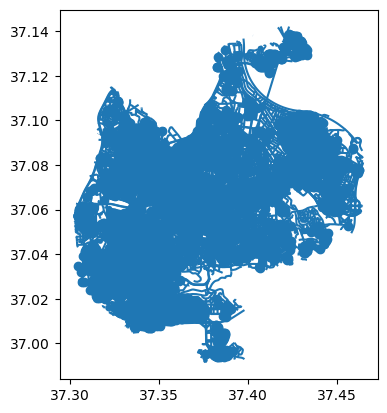

,obj_type,name,info,damage_gra,det_method,notation,or_src_id,dmg_src_id,cd_value,geometry,...,elec_cons,building_perm,land_permited,labour_fource,unemployment,agricultural,life_time,hb_per100000,fertility,hh_size
13140,"211-Highways, Streets and Roads",Unknown,21122-Local Road,No visible damage,Photo-interpretation,Not Applicable,994,3,Not Applicable,"LINESTRING (37.36569 37.06762, 37.36584 37.067...",...,4076,2959,3019546,50,10.1,3466185,76.9,306,2.47,3.97
13141,"211-Highways, Streets and Roads",Gaziantep-Osmaniye yolu,2111-Highways,No visible damage,Photo-interpretation,Not Applicable,994,2,Not Applicable,"LINESTRING (37.32444 37.11386, 37.32406 37.11424)",...,4076,2959,3019546,50,10.1,3466185,76.9,306,2.47,3.97
13142,"211-Highways, Streets and Roads",Unknown,21122-Local Road,No visible damage,Photo-interpretation,Not Applicable,994,3,Not Applicable,"LINESTRING (37.38112 36.99723, 37.38180 36.997...",...,4076,2959,3019546,50,10.1,3466185,76.9,306,2.47,3.97
13143,"211-Highways, Streets and Roads",Ferit Gingol Sokak,21122-Local Road,No visible damage,Photo-interpretation,Not Applicable,994,3,Not Applicable,"LINESTRING (37.32719 37.04785, 37.32679 37.047...",...,4076,2959,3019546,50,10.1,3466185,76.9,306,2.47,3.97
13144,"211-Highways, Streets and Roads",Unknown,21121-Secondary Road,No visible damage,Photo-interpretation,Not Applicable,994,3,Not Applicable,"LINESTRING (37.46407 37.06155, 37.46408 37.061...",...,4076,2959,3019546,50,10.1,3466185,76.9,306,2.47,3.97


In [31]:
#basic representations
plot_and_show_last(data_gaziantep)

    10.Golbasi:

Gölbaşı is a town and district in the Adıyaman Province of Turkey. It's located in the southeastern part of the country and is known for its natural beauty and cultural heritage. One of the main attractions of Gölbaşı is Lake Gölbaşı (Gölbaşı Gölü), a substantial body of water known for its diverse bird population and scenic beauty. The district also houses historical sites and landmarks, offering a peek into the region's rich history and traditions.

Info: https://en.wikipedia.org/wiki/G%C3%B6lba%C5%9F%C4%B1,_Ad%C4%B1yaman

Facilities, Buildings are saved in different locations

In [32]:
# paths for building and facility data
path_golbasi_b = '../data/vectors/GOLBASI/M1_V1/EMSR648_AOI13_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI13_GRA_MONIT01_builtUpP_r1_v1.shp'
path_golbasi_f = '../data/vectors/GOLBASI/M1_V1/EMSR648_AOI13_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI13_GRA_MONIT01_facilitiesA_r1_v1.shp'
path_golbasi2_b = '../data/vectors/GOLBASI/M2_V2/EMSR648_AOI13_GRA_MONIT02_r1_RTP01_v2_vector/EMSR648_AOI13_GRA_MONIT02_builtUpP_r1_v2.shp'
path_golbasi2_f = '../data/vectors/GOLBASI/M2_V2/EMSR648_AOI13_GRA_MONIT02_r1_RTP01_v2_vector/EMSR648_AOI13_GRA_MONIT02_facilitiesL_r1_v2.shp'
# ancillary data
path_golbasi_anc ='../data/vectors/GOLBASI/M1_V1/EMSR648_AOI13_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI13_GRA_MONIT01_ancillaryCrisisInfoP_r1_v1.shp'
# area of interest
path_golbasi_area = '../data/vectors/GOLBASI/M1_V1/EMSR648_AOI13_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI13_GRA_MONIT01_areaOfInterestA_r1_v1.shp'
# countour lines
path_golbasi_phisio = '../data/vectors/GOLBASI/M1_V1/EMSR648_AOI13_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI13_GRA_MONIT01_physiographyL_r1_v1.shp'
#water resources
path_golbasi_hidro = '../data/vectors/GOLBASI/M1_V1/EMSR648_AOI13_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI13_GRA_MONIT01_hydrographyL_r1_v1.shp'
#transportation daata
path_golbasi_transportation= '../data/vectors/GOLBASI/M1_V1/EMSR648_AOI13_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI13_GRA_MONIT01_transportationL_r1_v1.shp'

#merging building and facility data and adding area of interest
data_golbasi = (pd.concat([gpd.read_file(path_golbasi_b), gpd.read_file(path_golbasi_f),gpd.read_file(path_golbasi2_b), gpd.read_file(path_golbasi2_f), gpd.read_file(path_golbasi_transportation)])
                          .sjoin(gpd.read_file(path_golbasi_area), how='inner', op='within'))



/home/lapita/anaconda3/envs/tfm_graph/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [33]:
#adding population of last year and income in USD
data_golbasi['population'], data_golbasi['income'] =  50326, 4092
#total and second hand sales in the municipality in the last five years
data_golbasi['total_sales'], data_golbasi['second_sales'] =  6455, 2236

# percentage of accecing clean city water in the province
data_golbasi['water_access']= 0.98
#electric consumption of per capita
data_golbasi['elec_cons']= 2060
#number of buildings permited
data_golbasi['building_perm']= 810
#m2 of the land permited for construction
data_golbasi['land_permited'] = 695718
#labour force participation and unemployment rate in the province
data_golbasi['labour_fource'] = 50
data_golbasi['unemployment'] = 10.1

#agricultural area in decares
data_golbasi['agricultural'] = 2336012
#expected lifetinme

data_golbasi['life_time'] = 79.7
#number of hospitals and beds in the province per 100000 people
data_golbasi['hb_per100000']= 222
#fertility rate in the province
data_golbasi['fertility']= 2.36
#average household size
data_golbasi['hh_size']= 4


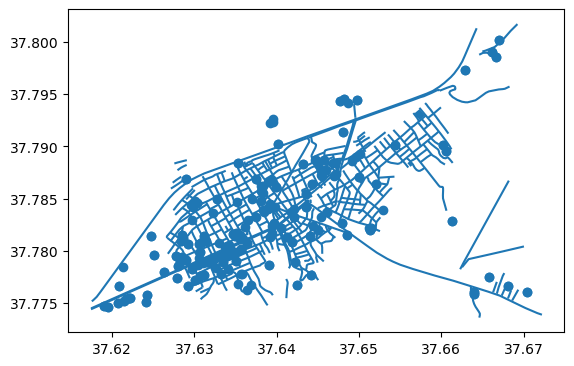

,obj_type,name,info,damage_gra,det_method,notation,or_src_id,dmg_src_id,cd_value,geometry,...,elec_cons,building_perm,land_permited,labour_fource,unemployment,agricultural,life_time,hb_per100000,fertility,hh_size
244,"211-Highways, Streets and Roads",Unknown,21124-Cart Track,No visible damage,Photo-interpretation,Not Applicable,994,2,Not Applicable,"LINESTRING (37.65981 37.79536, 37.66072 37.795...",...,2060,810,695718,50,10.1,2336012,79.7,222,2.36,4
245,"211-Highways, Streets and Roads",Unknown,21124-Cart Track,No visible damage,Photo-interpretation,Not Applicable,994,2,Not Applicable,"LINESTRING (37.66499 37.79912, 37.66535 37.799...",...,2060,810,695718,50,10.1,2336012,79.7,222,2.36,4
246,"211-Highways, Streets and Roads",Unknown,21124-Cart Track,No visible damage,Photo-interpretation,Not Applicable,994,2,Not Applicable,"LINESTRING (37.66758 37.80034, 37.66843 37.801...",...,2060,810,695718,50,10.1,2336012,79.7,222,2.36,4
247,"211-Highways, Streets and Roads",Unknown,21124-Cart Track,No visible damage,Photo-interpretation,Not Applicable,994,2,Not Applicable,"LINESTRING (37.66461 37.79881, 37.66506 37.798...",...,2060,810,695718,50,10.1,2336012,79.7,222,2.36,4
248,"211-Highways, Streets and Roads",Unknown,21122-Local Road,Possibly damaged,Photo-interpretation,Not Applicable,994,3,Not Applicable,"LINESTRING (37.64407 37.79091, 37.64414 37.790...",...,2060,810,695718,50,10.1,2336012,79.7,222,2.36,4


In [34]:
# Basic representations
plot_and_show_last(data_golbasi)

    11. Islahiye:

Islahiye is a town and district in the Gaziantep Province of southeastern Turkey. It is nestled between the Mediterranean and Southeastern Anatolia regions and is known for its rich history, agriculture, and diverse cultural heritage. Islahiye is surrounded by mountains and features fertile plains, making it a significant center for agriculture, particularly for growing cereals, legumes, and fruits. The area also has several ancient sites and ruins, reflecting its history that dates back to the Hittite period.

Info: https://en.wikipedia.org/wiki/%C4%B0slahiye_District 

Data has building and transportation information in different folders.

In [35]:
#data of Islahiye

#buildings

path_islahiye = '../data/vectors/ISLAHIYE/M1_V1/EMSR648_AOI10_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI10_GRA_MONIT01_builtUpA_r1_v1.shp'
path_islahiye2 = '../data/vectors/ISLAHIYE/M2_V1/EMSR648_AOI10_GRA_MONIT02_r1_RTP01_v1_vector/EMSR648_AOI10_GRA_MONIT02_builtUpA_r1_v1.shp'
#area of interest
path_islahiye_area = '../data/vectors/ISLAHIYE/M1_V1/EMSR648_AOI10_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI10_GRA_MONIT01_areaOfInterestA_r1_v1.shp'

#ancillary crisis info 
path_islahiye_anc1 = '../data/vectors/ISLAHIYE/M1_V1/EMSR648_AOI10_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI10_GRA_MONIT01_ancillaryCrisisInfoA_r1_v1.shp'

path_islahiye_anc2 = '../data/vectors/ISLAHIYE/M1_V1/EMSR648_AOI10_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI10_GRA_MONIT01_ancillaryCrisisInfoP_r1_v1.shp'
#water sources
path_islahiye_hidro= '../data/vectors/ISLAHIYE/M1_V1/EMSR648_AOI10_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI10_GRA_MONIT01_hydrographyL_r1_v1.shp'
# countour elevation
path_islahiye_physio = '../data/vectors/ISLAHIYE/M1_V1/EMSR648_AOI10_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI10_GRA_MONIT01_physiographyL_r1_v1.shp'
# roads
path_islahiye_transportation1= '../data/vectors/ISLAHIYE/M1_V1/EMSR648_AOI10_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI10_GRA_MONIT01_transportationA_r1_v1.shp'

path_islahiye_transportation2= '../data/vectors/ISLAHIYE/M1_V1/EMSR648_AOI10_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI10_GRA_MONIT01_transportationL_r1_v1.shp'

#merging buildings and area of interest
data_islahiye = (pd.concat([gpd.read_file(path_islahiye), gpd.read_file(path_islahiye2),gpd.read_file(path_islahiye2), gpd.read_file(path_islahiye_transportation1), gpd.read_file(path_islahiye_transportation2)])
                          .sjoin(gpd.read_file(path_islahiye_area), how='inner', op='within'))


/home/lapita/anaconda3/envs/tfm_graph/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [36]:
# Data from Turkish Statistical Institute (TUIK) 

data_islahiye['population'], data_islahiye['income'] =  67650, 7819
#total and second hand sales in the municipality in the last five years
data_islahiye['total_sales'], data_islahiye['second_sales'] =  4498, 1892

# percentage of accecing clean city water in the province
data_islahiye['water_access']= 1
#electric consumption of per capita
data_islahiye['elec_cons']=  4076
#number of buildings permited
data_islahiye['building_perm']=  2959
#m2 of the land permited for construction
data_islahiye['land_permited'] =  3019546
#labour force participation and unemployment rate in the province
data_islahiye['labour_fource'] =  50
data_islahiye['unemployment'] =  10.1
#agricultural area in decares
data_islahiye['agricultural'] =  3466185
#expected lifetinme
data_islahiye['life_time'] =  76.9
#number of hospitals and beds in the province per 100000 people
data_islahiye['hb_per100000']=  306
#fertility rate in the province
data_islahiye['fertility']=  2.47
#average household size
data_islahiye['hh_size']=  3.97


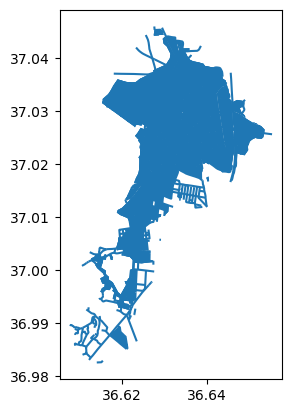

,obj_type,name,info,damage_gra,det_method,notation,or_src_id,dmg_src_id,cd_value,real,...,elec_cons,building_perm,land_permited,labour_fource,unemployment,agricultural,life_time,hb_per100000,fertility,hh_size
695,"211-Highways, Streets and Roads",Unknown,21122-Local Road,No visible damage,Photo-interpretation,Not Applicable,994,3,Not Applicable,NaN,...,4076,2959,3019546,50,10.1,3466185,76.9,306,2.47,3.97
696,"211-Highways, Streets and Roads",Unknown,21122-Local Road,Possibly damaged,Photo-interpretation,Not Applicable,994,3,Not Applicable,NaN,...,4076,2959,3019546,50,10.1,3466185,76.9,306,2.47,3.97
697,"211-Highways, Streets and Roads",Unknown,21122-Local Road,Possibly damaged,Photo-interpretation,Not Applicable,994,3,Not Applicable,NaN,...,4076,2959,3019546,50,10.1,3466185,76.9,306,2.47,3.97
698,"211-Highways, Streets and Roads",Unknown,21122-Local Road,Possibly damaged,Photo-interpretation,Not Applicable,994,3,Not Applicable,NaN,...,4076,2959,3019546,50,10.1,3466185,76.9,306,2.47,3.97
699,"211-Highways, Streets and Roads",Unknown,21122-Local Road,Possibly damaged,Photo-interpretation,Not Applicable,994,3,Not Applicable,NaN,...,4076,2959,3019546,50,10.1,3466185,76.9,306,2.47,3.97


In [37]:
#bsic repreentation of data
plot_and_show_last(data_islahiye)

    12. Kahramanmaras:

Kahramanmaraş is a city in the Mediterranean Region of Turkey and the administrative center of Kahramanmaraş Province. Known historically as Marash, the city has a rich history that stretches back to the Hittite civilization. It is renowned for its production of high-quality textiles, handcrafted goods, and notably, its distinctive ice cream, also known as Maras ice cream, which is famously chewy and dense. In terms of geography, Kahramanmaraş is surrounded by mountains and has a typical Mediterranean climate with hot, dry summers and mild, wet winters. The city's cultural heritage, coupled with its vibrant local industries, makes it a significant center in the region. Please note that as of my last training data cut-off in September 2021, certain current details or developments may not be included.

Info: https://en.wikipedia.org/wiki/Kahramanmara%C5%9F

Data of Kahramanmaras has 2 different files for water resources. main dataset will include building, facility and transportation

In [38]:
# Data Kahramanmaras

#buildings

path_kahramanmaras_b= '../data/vectors/KAHRAMANMARAS/M1_V1/EMSR648_AOI04_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI04_GRA_MONIT01_builtUpP_r1_v1.shp'

#facilities
path_kahramanmaras_f = '../data/vectors/KAHRAMANMARAS/M1_V1/EMSR648_AOI04_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI04_GRA_MONIT01_facilitiesA_r1_v1.shp'

#area of interest
path_kahramanmaras_area = '../data/vectors/KAHRAMANMARAS/M1_V1/EMSR648_AOI04_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI04_GRA_MONIT01_areaOfInterestA_r1_v1.shp'
#ancillary crisis info

path_kahramanmaras_anc = '../data/vectors/KAHRAMANMARAS/M1_V1/EMSR648_AOI04_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI04_GRA_MONIT01_ancillaryCrisisInfoP_r1_v1.shp'

#water resources
path_kahramanmaras_hidroA = '../data/vectors/KAHRAMANMARAS/M1_V1/EMSR648_AOI04_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI04_GRA_MONIT01_hydrographyA_r1_v1.shp'

path_kahramanmaras_hidroL = '../data/vectors/KAHRAMANMARAS/M1_V1/EMSR648_AOI04_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI04_GRA_MONIT01_hydrographyL_r1_v1.shp'

#transportation/roads
path_kahramanmaras_transportation = '../data/vectors/KAHRAMANMARAS/M1_V1/EMSR648_AOI04_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI04_GRA_MONIT01_transportationL_r1_v1.shp'
# Counter elevation
path_kahramanmaras_phisio = '../data/vectors/KAHRAMANMARAS/M1_V1/EMSR648_AOI04_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI04_GRA_MONIT01_physiographyL_r1_v1.shp'

# merging building, facilities and transportation and adding area of interest
data_kahramanmaras = (pd.concat([gpd.read_file(path_kahramanmaras_b), gpd.read_file(path_kahramanmaras_f), gpd.read_file(path_kahramanmaras_transportation)])
                      .sjoin(gpd.read_file(path_kahramanmaras_area), how='inner', op='within'))


/home/lapita/anaconda3/envs/tfm_graph/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [39]:
#adding population of last year and income in USD
data_kahramanmaras['population'], data_kahramanmaras['income'] = 806936, 5997
#total and second hand sales in the municipality in the last five years
data_kahramanmaras['total_sales'], data_kahramanmaras['second_sales'] =  87599, 42683

# percentage of accecing clean city water in the province
data_kahramanmaras['water_access']= 0.95
#electric consumption of per capita
data_kahramanmaras['elec_cons']= 4343
#number of buildings permited
data_kahramanmaras['building_perm']= 1528
#m2 of the land permited for construction in province
data_kahramanmaras['land_permited'] = 2222311
#labour force participation and unemployment rate in the province
data_kahramanmaras['labour_fource'] = 48.1
data_kahramanmaras['unemployment'] = 17.1

#agricultural area in decares
data_kahramanmaras['agricultural'] = 3535085
#expected lifetinme
data_kahramanmaras['life_time'] = 79.2
#number of hospitals and beds in the province per 100000 people
data_kahramanmaras['hb_per100000']= 256
#fertility rate in the province
data_kahramanmaras['fertility']= 1.99
#average household size
data_kahramanmaras['hh_size']= 3.68


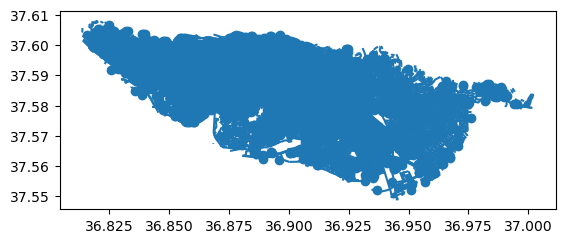

,obj_type,name,info,damage_gra,det_method,notation,or_src_id,dmg_src_id,cd_value,geometry,...,elec_cons,building_perm,land_permited,labour_fource,unemployment,agricultural,life_time,hb_per100000,fertility,hh_size
7838,212-Railways,Unknown,2121-Long-distance railways,No visible damage,Photo-interpretation,Not Applicable,994,3,Not Applicable,"LINESTRING (36.93545 37.56224, 36.93490 37.562...",...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68
7839,212-Railways,Unknown,2121-Long-distance railways,No visible damage,Photo-interpretation,Not Applicable,994,3,Not Applicable,"LINESTRING (36.93251 37.56333, 36.93218 37.563...",...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68
7840,212-Railways,Unknown,2121-Long-distance railways,No visible damage,Photo-interpretation,Not Applicable,994,3,Not Applicable,"LINESTRING (36.92477 37.56602, 36.92490 37.565...",...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68
7841,212-Railways,Unknown,2121-Long-distance railways,No visible damage,Photo-interpretation,Not Applicable,994,3,Not Applicable,"LINESTRING (36.93059 37.56400, 36.93217 37.563...",...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68
7842,212-Railways,Unknown,2121-Long-distance railways,No visible damage,Photo-interpretation,Not Applicable,994,3,Not Applicable,"LINESTRING (36.91965 37.56790, 36.92145 37.567...",...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68


In [40]:
# Basic representation of the data
plot_and_show_last(data_kahramanmaras)

    13. Kirikhan:

Kırıkhan is a town and district in the Hatay Province of southern Turkey. It's known for its location along the historical Silk Road and its proximity to the Syrian border, which contributes to its diverse cultural heritage. The district is a hub of agriculture and trade, with its economy primarily based on farming, particularly of citrus fruits, olives, and various grains.

Info: https://en.wikipedia.org/wiki/K%C4%B1r%C4%B1khan

Dataset consist of building and transportation data.

In [41]:
#data of Kirikhan

#buildings

path_kirikhan = '../data/vectors/KIRIKHAN/V1/EMSR648_AOI18_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI18_GRA_PRODUCT_builtUpP_r1_v1.shp'

#area of interest
path_kirikhan_area = '../data/vectors/KIRIKHAN/V1/EMSR648_AOI18_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI18_GRA_PRODUCT_areaOfInterestA_r1_v1.shp'

#ancillary crisis info
path_kirikhan_anc = '../data/vectors/KIRIKHAN/V1/EMSR648_AOI18_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI18_GRA_PRODUCT_ancillaryCrisisInfoP_r1_v1.shp'

#transportation/roads
path_kirikhan_transportation = '../data/vectors/KIRIKHAN/V1/EMSR648_AOI18_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI18_GRA_PRODUCT_transportationL_r1_v1.shp'

#elevation countours
path_kirikhan_phsio = '../data/vectors/KIRIKHAN/V1/EMSR648_AOI18_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI18_GRA_PRODUCT_physiographyL_r1_v1.shp'


#Water resources
path_kirikhan_hidro = '../data/vectors/KIRIKHAN/V1/EMSR648_AOI18_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI18_GRA_PRODUCT_hydrographyL_r1_v1.shp'


#merging all the data
data_kirikhan = (pd.concat([gpd.read_file(path_kirikhan), gpd.read_file(path_kirikhan_transportation)])
                 .sjoin(gpd.read_file(path_kirikhan_area), how='inner', op='within'))




/home/lapita/anaconda3/envs/tfm_graph/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [42]:
data_kirikhan['population'], data_kirikhan['income'] =  121028,  6785
#total and second hand sales in the municipality in the last five years
data_kirikhan['total_sales'], data_kirikhan['second_sales'] =  12466, 5881

# percentage of accecing clean city water in the province
data_kirikhan['water_access']= .99
#electric consumption of per capita
data_kirikhan['elec_cons']= 3984
#number of buildings permited
data_kirikhan['building_perm']= 1763
#m2 of the land permited for construction
data_kirikhan['land_permited'] =  2133640
#labour force participation and unemployment rate in the province
data_kirikhan['labour_fource'] = 48.1
data_kirikhan['unemployment'] = 17.1
#agricultural area in decares
data_kirikhan['agricultural'] = 353508523
#expected lifetinme
data_kirikhan['life_time'] = 77.9
#number of hospitals and beds in the province per 100000 people
data_kirikhan['hb_per100000']= 266
#fertility rate in the province
data_kirikhan['fertility']= 2.41
#average household size
data_kirikhan['hh_size']= 3.65

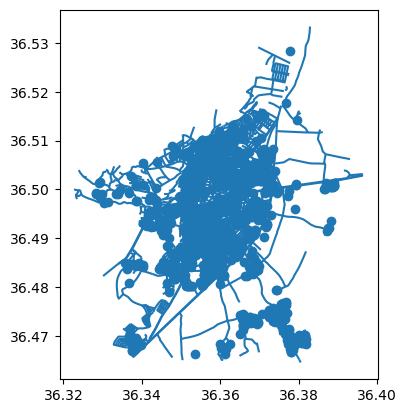

,obj_type,name,info,damage_gra,det_method,notation,or_src_id,dmg_src_id,cd_value,geometry,...,elec_cons,building_perm,land_permited,labour_fource,unemployment,agricultural,life_time,hb_per100000,fertility,hh_size
910,"211-Highways, Streets and Roads",Unknown,997-Not Applicable,No visible damage,Photo-interpretation,Not Applicable,994,2,Not Applicable,"LINESTRING (36.37760 36.46767, 36.37763 36.467...",...,3984,1763,2133640,48.1,17.1,353508523,77.9,266,2.41,3.65
911,"211-Highways, Streets and Roads",Unknown,21122-Local Road,Possibly damaged,Photo-interpretation,Not Applicable,994,2,Not Applicable,"LINESTRING (36.36601 36.49997, 36.36604 36.499...",...,3984,1763,2133640,48.1,17.1,353508523,77.9,266,2.41,3.65
912,"211-Highways, Streets and Roads",Unknown,21122-Local Road,Possibly damaged,Photo-interpretation,Not Applicable,994,2,Not Applicable,"LINESTRING (36.35887 36.50122, 36.35859 36.50127)",...,3984,1763,2133640,48.1,17.1,353508523,77.9,266,2.41,3.65
913,"211-Highways, Streets and Roads",Unknown,21122-Local Road,No visible damage,Photo-interpretation,Not Applicable,994,2,Not Applicable,"LINESTRING (36.35884 36.50109, 36.35868 36.500...",...,3984,1763,2133640,48.1,17.1,353508523,77.9,266,2.41,3.65
914,"211-Highways, Streets and Roads",Unknown,21122-Local Road,Possibly damaged,Photo-interpretation,Not Applicable,994,2,Not Applicable,"LINESTRING (36.35896 36.50149, 36.35887 36.501...",...,3984,1763,2133640,48.1,17.1,353508523,77.9,266,2.41,3.65


In [43]:
#basic representations
plot_and_show_last(data_kirikhan)

    14. Malatya:

Malatya is a large city and the capital of Malatya Province in eastern Turkey. Known for its rich history that dates back to the Hittites, the city is also renowned as a major producer of apricots, particularly the sun-dried variant, which is exported worldwide and is integral to the local economy. Malatya features a mix of modern urban development and historical sites, including the ancient city of Aslantepe, offering a unique blend of the past and the present.

Info: https://en.wikipedia.org/wiki/Malatya_Province 

Data includes buildings and transportation.

In [44]:
# Data for Malatya

#buildings

path_malatya = '../data/vectors/MALATYA/V1_VEC/EMSR648_AOI05_GRA_PRODUCT_r1_VECTORS_v1_vector/EMSR648_AOI05_GRA_PRODUCT_builtUpA_r1_v1.shp'

#area of interest
path_malatya_area = '../data/vectors/MALATYA/V1_VEC/EMSR648_AOI05_GRA_PRODUCT_r1_VECTORS_v1_vector/EMSR648_AOI05_GRA_PRODUCT_areaOfInterestA_r1_v1.shp'
#ancilarry  Crisi Info
path_malatya_anc = '../data/vectors/MALATYA/V1_VEC/EMSR648_AOI05_GRA_PRODUCT_r1_VECTORS_v1_vector/EMSR648_AOI05_GRA_PRODUCT_ancillaryCrisisInfoP_r1_v1.shp'

path_malatya_anc2 = '../data/vectors/MALATYA/V1_VEC/EMSR648_AOI05_GRA_PRODUCT_r1_VECTORS_v1_vector/EMSR648_AOI05_GRA_PRODUCT_ancillaryCrisisInfoA_r1_v1.shp'
#Water resources
path_malatya_hidro1 = '../data/vectors/MALATYA/V1_VEC/EMSR648_AOI05_GRA_PRODUCT_r1_VECTORS_v1_vector/EMSR648_AOI05_GRA_PRODUCT_hydrographyA_r1_v1.shp'
path_malatya_hidro2 = '../data/vectors/MALATYA/V1_VEC/EMSR648_AOI05_GRA_PRODUCT_r1_VECTORS_v1_vector/EMSR648_AOI05_GRA_PRODUCT_hydrographyL_r1_v1.shp'
#Transportation
path_malatya_transportation = '../data/vectors/MALATYA/V1_VEC/EMSR648_AOI05_GRA_PRODUCT_r1_VECTORS_v1_vector/EMSR648_AOI05_GRA_PRODUCT_transportationL_r1_v1.shp'
#Elevation contours
path_malatya_phsio = '../data/vectors/MALATYA/V1_VEC/EMSR648_AOI05_GRA_PRODUCT_r1_VECTORS_v1_vector/EMSR648_AOI05_GRA_PRODUCT_physiographyL_r1_v1.shp'

#merging all data
data_malatya = (pd.concat([gpd.read_file(path_malatya), gpd.read_file(path_malatya_transportation)])
                .sjoin(gpd.read_file(path_malatya_area), how='inner', op='within'))


/home/lapita/anaconda3/envs/tfm_graph/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [45]:
#adding statistical data for the province of Malatya

data_malatya['population'], data_malatya['income'] =  853658,  7819
#total and second hand sales in the municipality in the last five years
data_malatya['total_sales'], data_malatya['second_sales'] =  96737, 58495

# percentage of accecing clean city water in the province
data_malatya['water_access']= 1
#electric consumption of per capita
data_malatya['elec_cons']=  2031
#number of buildings permited
data_malatya['building_perm']=  1829
#m2 of the land permited for construction
data_malatya['land_permited'] =  1743251
#labour force participation and unemployment rate in the province
data_malatya['labour_fource'] =  48.3
data_malatya['unemployment'] =  10.2
#agricultural area in decares
data_malatya['agricultural'] =  2729948  
#expected lifetinme
data_malatya['life_time'] =  79.0
#number of hospitals and beds in the province per 100000 people
data_malatya['hb_per100000']=  369
#fertility rate in the province
data_malatya['fertility']=  1.63
#average household size
data_malatya['hh_size']=  3.40


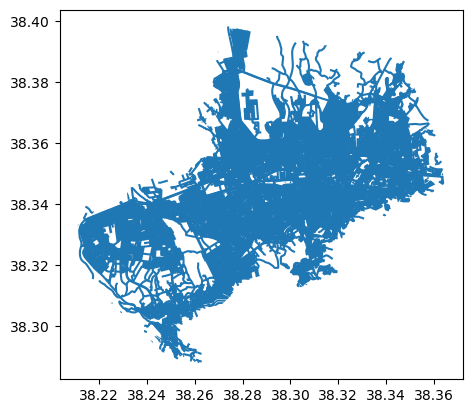

,obj_type,name,info,damage_gra,det_method,notation,or_src_id,dmg_src_id,cd_value,real,...,elec_cons,building_perm,land_permited,labour_fource,unemployment,agricultural,life_time,hb_per100000,fertility,hh_size
4740,"211-Highways, Streets and Roads",Unknown,21122-Local Road,Possibly damaged,Photo-interpretation,Not Applicable,994,2,Not Applicable,NaN,...,2031,1829,1743251,48.3,10.2,2729948,79.0,369,1.63,3.4
4741,"211-Highways, Streets and Roads",Unknown,21122-Local Road,Possibly damaged,Photo-interpretation,Not Applicable,994,2,Not Applicable,NaN,...,2031,1829,1743251,48.3,10.2,2729948,79.0,369,1.63,3.4
4742,"211-Highways, Streets and Roads",Unknown,21122-Local Road,No visible damage,Photo-interpretation,Not Applicable,994,2,Not Applicable,NaN,...,2031,1829,1743251,48.3,10.2,2729948,79.0,369,1.63,3.4
4743,"211-Highways, Streets and Roads",Unknown,21122-Local Road,Possibly damaged,Photo-interpretation,Not Applicable,994,2,Not Applicable,NaN,...,2031,1829,1743251,48.3,10.2,2729948,79.0,369,1.63,3.4
4744,"211-Highways, Streets and Roads",Zencefil Sokak,21122-Local Road,Possibly damaged,Photo-interpretation,Not Applicable,994,2,Not Applicable,NaN,...,2031,1829,1743251,48.3,10.2,2729948,79.0,369,1.63,3.4


In [46]:
#basic representations of the data
plot_and_show_last(data_malatya)

    15. Nurdagi:

Nurdagi is a town and district located in the Gaziantep Province of southeastern Turkey. Known for its rich agriculture, Nurdagi is situated in a fertile region where various crops such as wheat, barley, lentils, and chickpeas are grown. As of my last update in September 2021, it was a relatively small town that retained a traditional, rural lifestyle, offering a glimpse into the everyday life of southeastern Anatolia. Please consult more recent resources for the most current information.

Info: https://en.wikipedia.org/wiki/Nurda%C4%9F%C4%B1

In dataset aciliary and transportation is represented in different datasets.



In [47]:
#Data of Nurdagi

#buildings

path_nurdagi = '../data/vectors/NURDAGI/M1_V1/EMSR648_AOI16_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI16_GRA_MONIT01_builtUpA_r1_v1.shp'

#ancillary
path_nurdagi_anc1 = '../data/vectors/NURDAGI/M1_V1/EMSR648_AOI16_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI16_GRA_MONIT01_ancillaryCrisisInfoA_r1_v1.shp'

path_nurdagi_anc2 = '../data/vectors/NURDAGI/M1_V1/EMSR648_AOI16_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI16_GRA_MONIT01_ancillaryCrisisInfoP_r1_v1.shp'

#area of interest
path_nurdagi_area = '../data/vectors/NURDAGI/M1_V1/EMSR648_AOI16_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI16_GRA_MONIT01_areaOfInterestA_r1_v1.shp'

#water sources
path_nurdagi_hidro = '../data/vectors/NURDAGI/M1_V1/EMSR648_AOI16_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI16_GRA_MONIT01_hydrographyL_r1_v1.shp'

#contour elevation
path_nurdagi_physio = '../data/vectors/NURDAGI/M1_V1/EMSR648_AOI16_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI16_GRA_MONIT01_physiographyL_r1_v1.shp'

#transportation datasets.
path_nurdagi_transportation1 = '../data/vectors/NURDAGI/M1_V1/EMSR648_AOI16_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI16_GRA_MONIT01_transportationL_r1_v1.shp'

path_nurdagi_transportation2 = '../data/vectors/NURDAGI/M1_V1/EMSR648_AOI16_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI16_GRA_MONIT01_transportationP_r1_v1.shp'

#merging all data
data_nurdagi = (pd.concat([gpd.read_file(path_nurdagi), gpd.read_file(path_nurdagi_transportation1),gpd.read_file(path_nurdagi_transportation2)])
                .sjoin(gpd.read_file(path_nurdagi_area), how='inner', op='within'))


/home/lapita/anaconda3/envs/tfm_graph/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [48]:
data_nurdagi['population'], data_nurdagi['income'] = 41322, 7819
#total and second hand sales in the municipality in the last five years
data_nurdagi['total_sales'], data_nurdagi['second_sales'] = 3019, 1060

# percentage of accecing clean city water in the province
data_nurdagi['water_access']= 0.99


# percentage of accecing clean city water in the province
data_nurdagi['water_access']= 1
#electric consumption of per capita
data_nurdagi['elec_cons']=  4076
#number of buildings permited
data_nurdagi['building_perm']=  2959
#m2 of the land permited for construction
data_nurdagi['land_permited'] =  3019546
#labour force participation and unemployment rate in the province
data_nurdagi['labour_fource'] =  50
data_nurdagi['unemployment'] =  10.1
#agricultural area in decares
data_nurdagi['agricultural'] =  3466185
#expected lifetinme
data_nurdagi['life_time'] =  76.9
#number of hospitals and beds in the province per 100000 people
data_nurdagi['hb_per100000']=  306
#fertility rate in the province
data_nurdagi['fertility']=  2.47
#average household size
data_nurdagi['hh_size']=  3.9


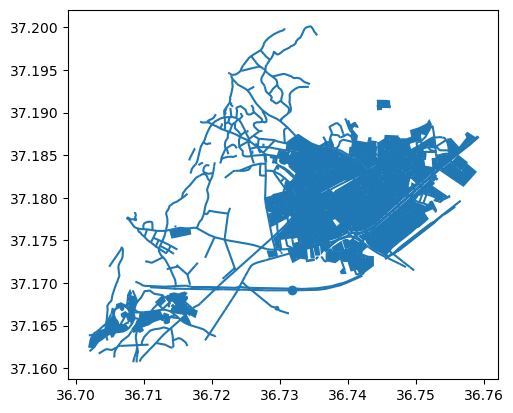

,obj_type,name,info,damage_gra,det_method,notation,or_src_id,dmg_src_id,cd_value,real,...,elec_cons,building_perm,land_permited,labour_fource,unemployment,agricultural,life_time,hb_per100000,fertility,hh_size
538,"211-Highways, Streets and Roads",Unknown,21122-Local Road,Possibly damaged,Photo-interpretation,Not Applicable,994,997,Not Applicable,NaN,...,4076,2959,3019546,50,10.1,3466185,76.9,306,2.47,3.9
539,"211-Highways, Streets and Roads",Unknown,21122-Local Road,Possibly damaged,Photo-interpretation,Not Applicable,994,997,Not Applicable,NaN,...,4076,2959,3019546,50,10.1,3466185,76.9,306,2.47,3.9
540,"211-Highways, Streets and Roads",Unknown,21122-Local Road,Not Analysed,Photo-interpretation,Not Applicable,1,997,Not Applicable,NaN,...,4076,2959,3019546,50,10.1,3466185,76.9,306,2.47,3.9
541,"211-Highways, Streets and Roads",Unknown,21122-Local Road,Damaged,Photo-interpretation,Not Applicable,1,997,Not Applicable,NaN,...,4076,2959,3019546,50,10.1,3466185,76.9,306,2.47,3.9
0,"214-Bridges, Elevated Highways, Tunnels and Su...",Unknown,2141-Bridges and elevated highways,Damaged,Photo-interpretation,Not Applicable,1,3,Not Applicable,NaN,...,4076,2959,3019546,50,10.1,3466185,76.9,306,2.47,3.9


In [49]:
#basic representtions

plot_and_show_last(data_nurdagi)

    16.Osmaniye:

Osmaniye is a city in southern Turkey and the capital of Osmaniye Province. Situated in the fertile Çukurova plain, the city is surrounded by mountains and is known for its agricultural production, particularly of peanuts and olives. Osmaniye is also home to several archaeological sites and historic landmarks, including the ancient city of Karatepe, which hosts a significant collection of Hittite relics. The city reflects a mix of the old and the new, with modern developments coexisting with traditional lifestyles and historical heritage. 

Info: https://en.wikipedia.org/wiki/Osmaniye

In dataset facilities are represented in 2 files. Osmaniye data includes transportation, facilities and buildings data.

In [50]:
#dataset for Osmaniye

#buildings
path_osmaniye_b= '../data/vectors/OSMANIYE/M1_V2/EMSR648_AOI06_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI06_GRA_MONIT01_builtUpA_r1_v2.shp'

#facilities
path_osmaniye_f= '../data/vectors/OSMANIYE/M1_V2/EMSR648_AOI06_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI06_GRA_MONIT01_facilitiesL_r1_v2.shp'
path_osmaniye_f2= '../data/vectors/OSMANIYE/M1_V2/EMSR648_AOI06_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI06_GRA_MONIT01_facilitiesL_r1_v2.shp'

#area of interest
path_osmaniye_area = '../data/vectors/OSMANIYE/M1_V2/EMSR648_AOI06_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI06_GRA_MONIT01_areaOfInterestA_r1_v2.shp'
#ancillary crisis info
path_osmaniye_anc = '../data/vectors/OSMANIYE/M1_V2/EMSR648_AOI06_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI06_GRA_MONIT01_ancillaryCrisisInfoP_r1_v2.shp'
#water sources
path_osmaniye_hidro = '../data/vectors/OSMANIYE/M1_V2/EMSR648_AOI06_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI06_GRA_MONIT01_hydrographyL_r1_v2.shp'
# contours elevation
path_osmaniye_physio = '../data/vectors/OSMANIYE/M1_V2/EMSR648_AOI06_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI06_GRA_MONIT01_physiographyL_r1_v2.shp'
#transportation
path_osmaniye_transportation = '../data/vectors/OSMANIYE/M1_V2/EMSR648_AOI06_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI06_GRA_MONIT01_transportationL_r1_v2.shp'

#merging all data
data_osmaniye = (pd.concat([gpd.read_file(path_osmaniye_b), gpd.read_file(path_osmaniye_f), gpd.read_file(path_osmaniye_f2), gpd.read_file(path_osmaniye_transportation)]).
                 sjoin(gpd.read_file(path_osmaniye_area), how='inner', op='within'))


/home/lapita/anaconda3/envs/tfm_graph/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [51]:
#additional data for Osmaniye
#population and income
data_osmaniye['population'], data_osmaniye['income'] =  285430, 6256
#total and second hand sales in the municipality in the last five years
data_osmaniye['total_sales'], data_osmaniye['second_sales'] =  32782, 19933


# percentage of accecing clean city water in the province
data_osmaniye['water_access']= 0.95
#electric consumption of per capita
data_osmaniye['elec_cons']= 7413

#number of buildings permited
data_osmaniye['building_perm']= 583
#m2 of the land permited for construction
data_osmaniye['land_permited'] =  782505
#labour force participation and unemployment rate in the province
data_osmaniye['labour_fource'] = 48.1
data_osmaniye['unemployment'] = 17.1
#agricultural area in decares
data_osmaniye['agricultural'] = 1233061
#expected lifetinme
data_osmaniye['life_time'] = 78
#number of hospitals and beds in the province per 100000 people
data_osmaniye['hb_per100000']= 246
#fertility rate in the province
data_osmaniye['fertility']= 1.92
#average household size
data_osmaniye['hh_size']= 3.46



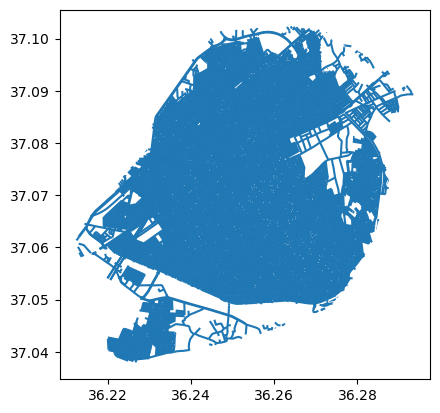

,obj_type,name,info,damage_gra,det_method,notation,or_src_id,dmg_src_id,cd_value,real,...,elec_cons,building_perm,land_permited,labour_fource,unemployment,agricultural,life_time,hb_per100000,fertility,hh_size
3033,"211-Highways, Streets and Roads",Åehit Yusuf ÅanlÄ± Sokak,21122-Local Road,Possibly damaged,Photo-interpretation,Not Applicable,994,3,Not Applicable,NaN,...,7413,583,782505,48.1,17.1,1233061,78,246,1.92,3.46
3034,"211-Highways, Streets and Roads",Kayalar Sokak,21122-Local Road,Possibly damaged,Photo-interpretation,Not Applicable,994,3,Not Applicable,NaN,...,7413,583,782505,48.1,17.1,1233061,78,246,1.92,3.46
3035,"211-Highways, Streets and Roads",Oktay Cirit Sokak,21122-Local Road,Not Analysed,Photo-interpretation,Not Applicable,994,3,Not Applicable,NaN,...,7413,583,782505,48.1,17.1,1233061,78,246,1.92,3.46
3036,"211-Highways, Streets and Roads",Unknown,21122-Local Road,Not Analysed,Photo-interpretation,Not Applicable,994,3,Not Applicable,NaN,...,7413,583,782505,48.1,17.1,1233061,78,246,1.92,3.46
3037,"211-Highways, Streets and Roads",Unknown,21122-Local Road,Not Analysed,Photo-interpretation,Not Applicable,994,3,Not Applicable,NaN,...,7413,583,782505,48.1,17.1,1233061,78,246,1.92,3.46


In [52]:
#Basic Representations

plot_and_show_last(data_osmaniye)


    17. Pazarcik:

Pazarcık is a town and district located in Kahramanmaraş Province in southern Turkey. Known for its agricultural industry, the district is primarily involved in the cultivation of crops like wheat, barley, and corn. Its name, which translates to "little market" in Turkish, hints at its historical roots as a trading center. Pazarcık has a mix of rural and urban areas, offering a glimpse into the region's traditional lifestyle alongside modern development. 

Info: https://en.wikipedia.org/wiki/Pazarc%C4%B1k

We have facilities representes in 2 different file, buildings and transportation.

In [53]:
#Pazarcik Data
#buildings

path_pazarcik_b = '../data/vectors/PAZARCIK/M1_V1/EMSR648_AOI08_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI08_GRA_MONIT01_builtUpP_r1_v1.shp'

#facilities
path_pazarcik_f = '../data/vectors/PAZARCIK/M1_V1/EMSR648_AOI08_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI08_GRA_MONIT01_facilitiesA_r1_v1.shp'
path_pazarcik_f2 = '../data/vectors/PAZARCIK/M1_V1/EMSR648_AOI08_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI08_GRA_MONIT01_facilitiesL_r1_v1.shp'

#area of interest
path_pazarcik_area = '../data/vectors/PAZARCIK/M1_V1/EMSR648_AOI08_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI08_GRA_MONIT01_areaOfInterestA_r1_v1.shp'
#ancillary
path_pazarcik_anc = '../data/vectors/PAZARCIK/M1_V1/EMSR648_AOI08_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI08_GRA_MONIT01_ancillaryCrisisInfoP_r1_v1.shp'
#water sources
path_pazarcik_hidro = '../data/vectors/PAZARCIK/M1_V1/EMSR648_AOI08_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI08_GRA_MONIT01_hydrographyA_r1_v1.shp'

#contour elevations
path_pazarcik_physio = '../data/vectors/PAZARCIK/M1_V1/EMSR648_AOI08_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI08_GRA_MONIT01_physiographyL_r1_v1.shp'

#transportation
path_pazarcik_transportation = '../data/vectors/PAZARCIK/M1_V1/EMSR648_AOI08_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI08_GRA_MONIT01_transportationL_r1_v1.shp'

#merging all data
data_pazarcik = (pd.concat([gpd.read_file(path_pazarcik_b), gpd.read_file(path_pazarcik_f), gpd.read_file(path_pazarcik_f2), gpd.read_file(path_pazarcik_transportation)])
                 .sjoin(gpd.read_file(path_pazarcik_area), how='inner', op='within'))




/home/lapita/anaconda3/envs/tfm_graph/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [54]:
#additional data for Pazarcik
#population and income

data_pazarcik['population'], data_pazarcik['income'] =  70173,  5997
#total and second hand sales in the municipality in the last five years
data_pazarcik['total_sales'], data_pazarcik['second_sales'] = 5747, 1932


# percentage of accecing clean city water in the province
data_pazarcik['water_access']= 0.95
#electric consumption of per capita
data_pazarcik['elec_cons']= 4343
#number of buildings permited
data_pazarcik['building_perm']= 1528
#m2 of the land permited for construction in province
data_pazarcik['land_permited'] = 2222311
#labour force participation and unemployment rate in the province
data_pazarcik['labour_fource'] = 48.1
data_pazarcik['unemployment'] = 17.1

#agricultural area in decares
data_pazarcik['agricultural'] = 3535085
#expected lifetinme
data_pazarcik['life_time'] = 79.2
#number of hospitals and beds in the province per 100000 people
data_pazarcik['hb_per100000']= 256
#fertility rate in the province
data_pazarcik['fertility']= 1.99
#average household size
data_pazarcik['hh_size']= 3.68



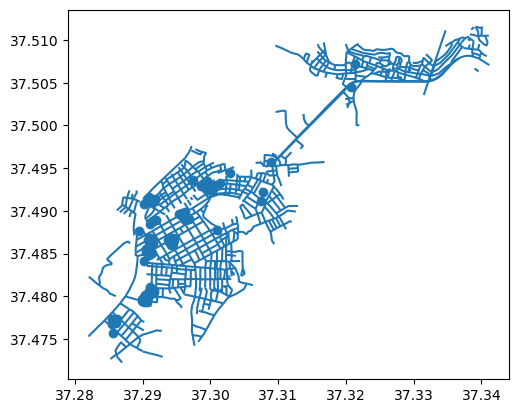

,obj_type,name,info,damage_gra,det_method,notation,or_src_id,dmg_src_id,cd_value,geometry,...,elec_cons,building_perm,land_permited,labour_fource,unemployment,agricultural,life_time,hb_per100000,fertility,hh_size
415,"211-Highways, Streets and Roads",Unknown,21124-Cart Track,Not Analysed,Not Applicable,Not Applicable,994,997,Not Applicable,"LINESTRING (37.28341 37.48136, 37.28350 37.481...",...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68
418,"211-Highways, Streets and Roads",Unknown,21124-Cart Track,Not Analysed,Not Applicable,Not Applicable,994,997,Not Applicable,"LINESTRING (37.31079 37.48838, 37.31143 37.488...",...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68
419,"211-Highways, Streets and Roads",Unknown,21124-Cart Track,Not Analysed,Not Applicable,Not Applicable,994,997,Not Applicable,"LINESTRING (37.30626 37.48130, 37.30547 37.48146)",...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68
421,"211-Highways, Streets and Roads",Unknown,21124-Cart Track,Not Analysed,Not Applicable,Not Applicable,994,997,Not Applicable,"LINESTRING (37.33898 37.50666, 37.33936 37.506...",...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68
423,212-Railways,Unknown,2121-Long-distance railways,Not Analysed,Not Applicable,Not Applicable,994,997,Not Applicable,"LINESTRING (37.29000 37.49097, 37.29031 37.491...",...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68


In [55]:
#Basic representation of the data
plot_and_show_last(data_pazarcik)

    18.Sanliurfa:

Şanlıurfa, often simply known as Urfa, is a city in southeastern Turkey, steeped in history and cultural heritage. The city is believed to be one of the oldest continuously inhabited cities in the world, with a history that dates back thousands of years to the time of the ancient civilizations of Mesopotamia. It's also traditionally associated with biblical history, being known as the "City of Prophets," with local lore identifying it as the birthplace of Abraham. Şanlıurfa is renowned for its unique cuisine, impressive architecture, including the old town with its traditional 'hans' and bazaars, and significant archaeological sites like Göbekli Tepe, often considered the world's oldest temple.

Info: https://en.wikipedia.org/wiki/Urfa

In sanliurfa data transportation in 2 different files. we will use building, facilities and transportation data

In [56]:
#Sanliurfa data
#buildings

path_sanliurfa_b = '../data/vectors/SANLIURFA/V1/EMSR648_AOI07_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI07_GRA_PRODUCT_builtUpA_r1_v1.shp'
#facilities
path_sanliurfa_f = '../data/vectors/SANLIURFA/V1/EMSR648_AOI07_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI07_GRA_PRODUCT_facilitiesA_r1_v1.shp'
#area of interest
path_sanliurfa_area = '../data/vectors/SANLIURFA/V1/EMSR648_AOI07_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI07_GRA_PRODUCT_areaOfInterestA_r1_v1.shp'
#transportation
path_sanliurfa_transportation1 = '../data/vectors/SANLIURFA/V1/EMSR648_AOI07_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI07_GRA_PRODUCT_transportationL_r1_v1.shp'

path_sanliurfa_transportation2 = '../data/vectors/SANLIURFA/V1/EMSR648_AOI07_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI07_GRA_PRODUCT_transportationA_r1_v1.shp'
#water sources
path_sanliurfa_hidro1 = '../data/vectors/SANLIURFA/V1/EMSR648_AOI07_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI07_GRA_PRODUCT_hydrographyA_r1_v1.shp'

path_sanliurfa_hidro2 = '../data/vectors/SANLIURFA/V1/EMSR648_AOI07_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI07_GRA_PRODUCT_hydrographyL_r1_v1.shp'

#elevation
path_sanliurfa_physio = '../data/vectors/SANLIURFA/V1/EMSR648_AOI07_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI07_GRA_PRODUCT_physiographyL_r1_v1.shp'

#merging all the data
data_sanliurfa = (pd.concat([gpd.read_file(path_sanliurfa_b), gpd.read_file(path_sanliurfa_f), gpd.read_file(path_sanliurfa_transportation1), gpd.read_file(path_sanliurfa_transportation2)])
                  .sjoin(gpd.read_file(path_sanliurfa_area), how='inner', op='within'))




/home/lapita/anaconda3/envs/tfm_graph/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [57]:
#additional information about the province
#income and population

data_sanliurfa['population'], data_sanliurfa['income'] =  2170110,  3012
#total and second hand sales in the municipality in the last five years
data_sanliurfa['total_sales'], data_sanliurfa['second_sales'] =  177626, 99010

# percentage of accecing clean city water in the province
data_sanliurfa['water_access']= 0.95
#electric consumption of per capita
data_sanliurfa['elec_cons']=  1631
#number of buildings permited
data_sanliurfa['building_perm']=  978
#m2 of the land permited for construction
data_sanliurfa['land_permited'] =  1189247
#labour force participation and unemployment rate in the province
data_sanliurfa['labour_fource'] =  40.6
data_sanliurfa['unemployment'] =  15.0
#agricultural area in decares
data_sanliurfa['agricultural'] =  10445551
#expected lifetinme
data_sanliurfa['life_time'] =  77.7
#number of hospitals and beds in the province per 100000 people
data_sanliurfa['hb_per100000']=  193
#fertility rate in the province
data_sanliurfa['fertility']=  3.81
#average household size
data_sanliurfa['hh_size']=  5.12

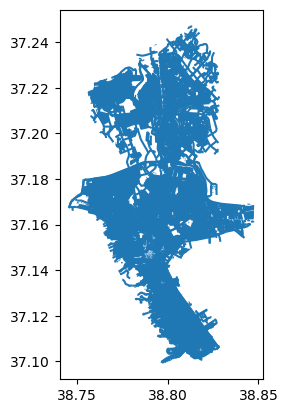

,obj_type,name,info,damage_gra,det_method,notation,or_src_id,dmg_src_id,cd_value,real,...,elec_cons,building_perm,land_permited,labour_fource,unemployment,agricultural,life_time,hb_per100000,fertility,hh_size
5633,"211-Highways, Streets and Roads",Unknown,21124-Cart Track,Not Analysed,Photo-interpretation,Not Applicable,1,2,Not Applicable,NaN,...,1631,978,1189247,40.6,15.0,10445551,77.7,193,3.81,5.12
0,213-Airfield,Unknown,2130-Airfield runways,No visible damage,Photo-interpretation,Not Applicable,994,2,Not Applicable,NaN,...,1631,978,1189247,40.6,15.0,10445551,77.7,193,3.81,5.12
1,213-Airfield,Unknown,21312-Helipad,No visible damage,Photo-interpretation,Not Applicable,994,2,Not Applicable,NaN,...,1631,978,1189247,40.6,15.0,10445551,77.7,193,3.81,5.12
2,213-Airfield,Unknown,21312-Helipad,No visible damage,Photo-interpretation,Not Applicable,994,2,Not Applicable,NaN,...,1631,978,1189247,40.6,15.0,10445551,77.7,193,3.81,5.12
3,213-Airfield,Unknown,21312-Helipad,No visible damage,Photo-interpretation,Not Applicable,994,2,Not Applicable,NaN,...,1631,978,1189247,40.6,15.0,10445551,77.7,193,3.81,5.12


In [58]:
#basic representation of the data   
plot_and_show_last(data_sanliurfa)

    19.Turkoglu:

Turkoğlu is a town and district in the Kahramanmaraş Province of southern Turkey. It's known for its agriculture, particularly the production of cereals, olive oil, and a variety of fruits and vegetables. The district's relatively mild Mediterranean climate contributes to its agricultural productivity.

Info: https://en.wikipedia.org/wiki/T%C3%BCrko%C4%9Flu

In [59]:
# Data of the Turkoglu

#buildings
path_turkoglu_b = '../data/vectors/TURKOGLU/V2/EMSR648_AOI17_GRA_PRODUCT_r1_RTP01_v2_vector/EMSR648_AOI17_GRA_PRODUCT_builtUpA_r1_v2.shp'
#facilities
path_turkoglu_f = '../data/vectors/TURKOGLU/V2/EMSR648_AOI17_GRA_PRODUCT_r1_RTP01_v2_vector/EMSR648_AOI17_GRA_PRODUCT_facilitiesA_r1_v2.shp'
#area of interest
path_turkoglu_area = '../data/vectors/TURKOGLU/V2/EMSR648_AOI17_GRA_PRODUCT_r1_RTP01_v2_vector/EMSR648_AOI17_GRA_PRODUCT_areaOfInterestA_r1_v2.shp'
#anclilarry
path_turkoglu_anc1 = '../data/vectors/TURKOGLU/V2/EMSR648_AOI17_GRA_PRODUCT_r1_RTP01_v2_vector/EMSR648_AOI17_GRA_PRODUCT_ancillaryCrisisInfoP_r1_v2.shp'

path_turkoglu_anc2 = '../data/vectors/TURKOGLU/V2/EMSR648_AOI17_GRA_PRODUCT_r1_RTP01_v2_vector/EMSR648_AOI17_GRA_PRODUCT_ancillaryCrisisInfoA_r1_v2.shp'

#water sources
path_turkoglu_hidro = '../data/vectors/TURKOGLU/V2/EMSR648_AOI17_GRA_PRODUCT_r1_RTP01_v2_vector/EMSR648_AOI17_GRA_PRODUCT_hydrographyL_r1_v2.shp'

#transportation
path_turkoglu_transportation = '../data/vectors/TURKOGLU/V2/EMSR648_AOI17_GRA_PRODUCT_r1_RTP01_v2_vector/EMSR648_AOI17_GRA_PRODUCT_transportationL_r1_v2.shp'
#contour elevation
path_turkoglu_physio = '../data/vectors/TURKOGLU/V2/EMSR648_AOI17_GRA_PRODUCT_r1_RTP01_v2_vector/EMSR648_AOI17_GRA_PRODUCT_physiographyL_r1_v2.shp'

#merging all the data
data_turkoglu = (pd.concat([gpd.read_file(path_turkoglu_b), gpd.read_file(path_turkoglu_f), gpd.read_file(path_turkoglu_transportation)])
                 .sjoin(gpd.read_file(path_turkoglu_area), how='inner', op='within'))

/home/lapita/anaconda3/envs/tfm_graph/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [60]:
# statistical data of the province
#income and population of the province

data_turkoglu['population'], data_turkoglu['income'] =  78976,  5997
#total and second hand sales in the municipality in the last five years
data_turkoglu['total_sales'], data_turkoglu['second_sales'] = 1938, 536

# percentage of accecing clean city water in the province
data_turkoglu['water_access']= 0.95
#electric consumption of per capita
data_turkoglu['elec_cons']= 4343
#number of buildings permited
data_turkoglu['building_perm']= 1528
#m2 of the land permited for construction in province
data_turkoglu['land_permited'] = 2222311
#labour force participation and unemployment rate in the province
data_turkoglu['labour_fource'] = 48.1
data_turkoglu['unemployment'] = 17.1

#agricultural area in decares
data_turkoglu['agricultural'] = 3535085
#expected lifetinme
data_turkoglu['life_time'] = 79.2
#number of hospitals and beds in the province per 100000 people
data_turkoglu['hb_per100000']= 256
#fertility rate in the province
data_turkoglu['fertility']= 1.99
#average household size
data_turkoglu['hh_size']= 3.68

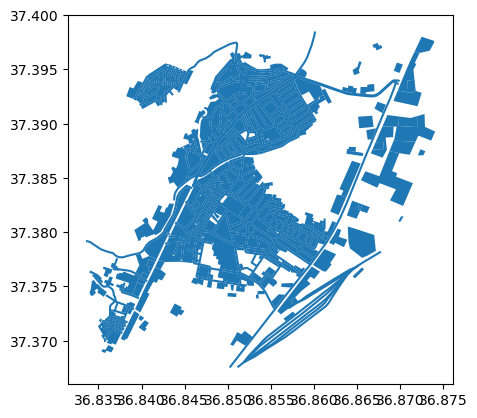

,obj_type,name,info,damage_gra,det_method,notation,or_src_id,dmg_src_id,cd_value,real,...,elec_cons,building_perm,land_permited,labour_fource,unemployment,agricultural,life_time,hb_per100000,fertility,hh_size
197,212-Railways,None,997-Not Applicable,No visible damage,Not Applicable,Not Applicable,994,2,Not Applicable,NaN,...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68
198,212-Railways,None,997-Not Applicable,No visible damage,Not Applicable,Not Applicable,994,2,Not Applicable,NaN,...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68
199,212-Railways,None,997-Not Applicable,No visible damage,Not Applicable,Not Applicable,994,2,Not Applicable,NaN,...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68
200,212-Railways,None,997-Not Applicable,No visible damage,Not Applicable,Not Applicable,994,2,Not Applicable,NaN,...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68
201,212-Railways,None,997-Not Applicable,No visible damage,Not Applicable,Not Applicable,994,2,Not Applicable,NaN,...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68


In [61]:
# Basic representationsof the data
plot_and_show_last(data_turkoglu)


So far, we have built foundational data for every unit in the dataset. The data can be combined using the 'concat' function along the columns.

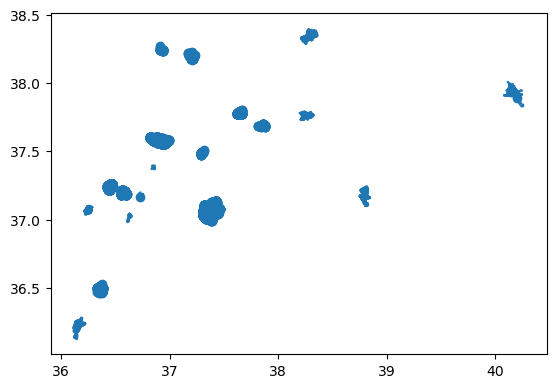

,obj_type,name,info,damage_gra,det_method,notation,or_src_id,dmg_src_id,cd_value,real,...,elec_cons,building_perm,land_permited,labour_fource,unemployment,agricultural,life_time,hb_per100000,fertility,hh_size
197,212-Railways,None,997-Not Applicable,No visible damage,Not Applicable,Not Applicable,994,2,Not Applicable,NaN,...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68
198,212-Railways,None,997-Not Applicable,No visible damage,Not Applicable,Not Applicable,994,2,Not Applicable,NaN,...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68
199,212-Railways,None,997-Not Applicable,No visible damage,Not Applicable,Not Applicable,994,2,Not Applicable,NaN,...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68
200,212-Railways,None,997-Not Applicable,No visible damage,Not Applicable,Not Applicable,994,2,Not Applicable,NaN,...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68
201,212-Railways,None,997-Not Applicable,No visible damage,Not Applicable,Not Applicable,994,2,Not Applicable,NaN,...,4343,1528,2222311,48.1,17.1,3535085,79.2,256,1.99,3.68


In [62]:
# Concataneting all data from different cities.

data = pd.concat([data_adiyaman, data_afsin, data_antakya, data_bahce, data_diyarbakir,
                  data_duzici, data_elbistan, data_erdemoglu,
                  data_gaziantep, data_golbasi, data_islahiye,
                  data_kahramanmaras, data_kirikhan, data_malatya, data_nurdagi, data_osmaniye,
                  data_pazarcik, data_sanliurfa, data_turkoglu])


#basic representations
plot_and_show_last(data)

### 3.2 Anciliaty information :
    

Anciliary points tend to cluster around areas close to the city center. Nevertheless, as we have observed in previous local analyses, some places lack this information. I aim to incorporate this data into the dataset since it holds significant importance to the buildings. We will carry out this operation on the entire dataset because in some smaller cities or villages, camping in the neighboring city could be more logical. Later, 

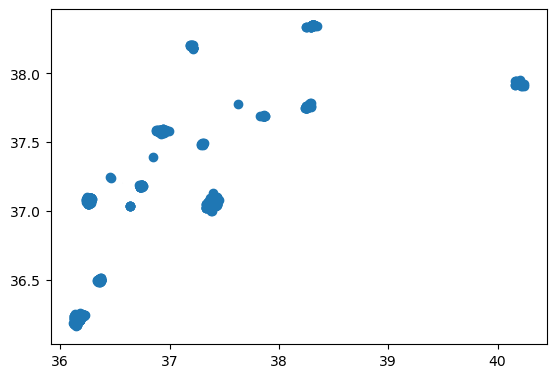

,obj_type,element_co,obj_desc,det_method,notation,or_src_id,dmg_src_id,cd_value,geometry
0,Camp,997,Temporary camp,Photo-interpretation,Not Applicable,2,2,Not Applicable,"POLYGON ((36.86003 37.39211, 36.85924 37.39173..."
1,Camp,997,Temporary camp,Photo-interpretation,Not Applicable,2,2,Not Applicable,"POLYGON ((36.85150 37.38241, 36.85125 37.38215..."
2,Camp,997,Temporary camp,Photo-interpretation,Not Applicable,2,2,Not Applicable,"POLYGON ((36.84592 37.38454, 36.84580 37.38430..."
3,Camp,997,Temporary camp,Photo-interpretation,Not Applicable,2,2,Not Applicable,"POLYGON ((36.84660 37.38422, 36.84643 37.38394..."
4,Camp,997,Temporary camp,Photo-interpretation,Not Applicable,2,2,Not Applicable,"POLYGON ((36.84728 37.38316, 36.84681 37.38280..."


In [63]:
#concatanation of the ancillary datasets
data_anc = pd.concat([gpd.read_file(path_adiyaman_anc), gpd.read_file(path_adiyaman_anc2), gpd.read_file(path_antakya_anc1), gpd.read_file(path_antakya_anc2),
                      gpd.read_file(path_bahce_anc1), gpd.read_file(path_diyarbakir_anc), gpd.read_file(path_duzici_anc1), gpd.read_file(path_duzici_anc2),
                      gpd.read_file(path_elbistan_anc), gpd.read_file(path_erdemoglu_anc), gpd.read_file(path_gaziantep_anc),
                      gpd.read_file(path_golbasi_anc), gpd.read_file(path_islahiye_anc1), gpd.read_file(path_islahiye_anc2),
                      gpd.read_file(path_kahramanmaras_anc),gpd.read_file(path_kirikhan_anc), gpd.read_file(path_malatya_anc), 
                      gpd.read_file(path_nurdagi_anc1), gpd.read_file(path_nurdagi_anc2),gpd.read_file(path_osmaniye_anc), 
                      gpd.read_file(path_pazarcik_anc), gpd.read_file(path_turkoglu_anc1), gpd.read_file(path_turkoglu_anc2)])
plot_and_show_last(data_anc)


                   


### 3.3. Elevation Contour

This data is used to understand if the height of the building matters in to the damage. In later steps, with balltree method we will try to understand how much height the buildings have.

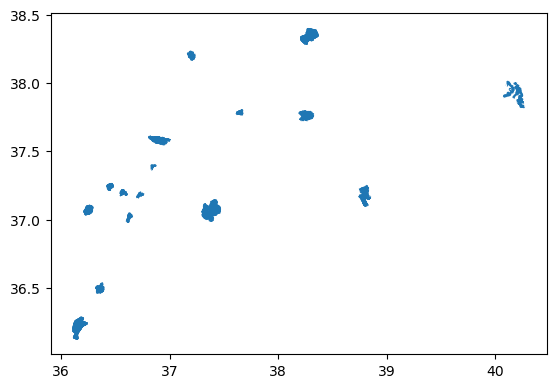

,obj_type,name,elev,notation,or_src_id,geometry
19,CA010-Elevation Contour,Unknown,525,Not Applicable,984,"LINESTRING (36.85473 37.39837, 36.85473 37.398..."
20,CA010-Elevation Contour,Unknown,500,Not Applicable,984,"LINESTRING (36.86931 37.39872, 36.86931 37.398..."
21,CA010-Elevation Contour,Unknown,550,Not Applicable,984,"LINESTRING (36.83354 37.37336, 36.83361 37.373..."
22,CA010-Elevation Contour,Unknown,525,Not Applicable,984,"LINESTRING (36.83354 37.37506, 36.83361 37.375..."
23,CA010-Elevation Contour,Unknown,500,Not Applicable,984,"LINESTRING (36.83354 37.37603, 36.83361 37.376..."


In [64]:
#concatanating all the physiography data
data_physio = pd.concat ([gpd.read_file(path_adiyaman_phisio), gpd.read_file(path_antakya_phisio), gpd.read_file(path_bahce_phisio),
                          gpd.read_file(path_diyarbakir_phisio), gpd.read_file(path_duzici_phisio), gpd.read_file(path_elbistan_phisio),
                          gpd.read_file(path_gaziantep_phisio), gpd.read_file(path_golbasi_phisio),
                          gpd.read_file(path_islahiye_physio), gpd.read_file(path_kahramanmaras_phisio), gpd.read_file(path_kirikhan_phsio),
                          gpd.read_file(path_malatya_phsio), gpd.read_file(path_nurdagi_physio), gpd.read_file(path_osmaniye_physio),
                          gpd.read_file(path_sanliurfa_physio), gpd.read_file(path_turkoglu_physio)])

plot_and_show_last(data_physio)

### 3.4. Water Sources

The Copernicus Disaster dataset also encompasses information on water sources, referred to as "Hydrography". This is a geographic variable that could potentially influence building safety. Therefore, it's essential that we factor this into our considerations.We might consider using the distance to water resources as a variable in our analysis.

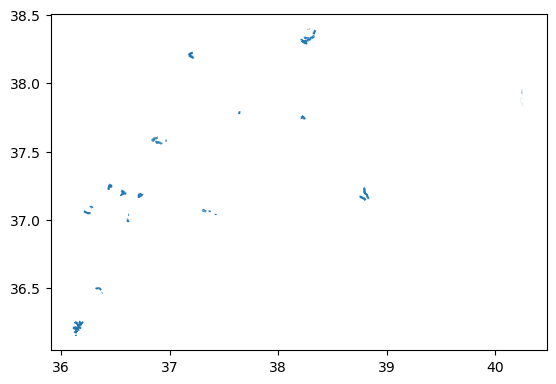

,obj_type,name,notation,or_src_id,cd_value,geometry
12,BH080-Lake,Unknown,Not Applicable,994,Not Applicable,"POLYGON ((38.80431 37.17823, 38.80451 37.17823..."
0,BH141-Stream,Karakoyun River,Not Applicable,994,Not Applicable,"LINESTRING (38.74901 37.16914, 38.74928 37.169..."
1,BH180-Waterfall,Unknown,Not Applicable,994,Not Applicable,"LINESTRING (38.82785 37.15809, 38.82793 37.160..."
2,BH141-Stream,Sulama KanalÄ±,Not Applicable,994,Not Applicable,"LINESTRING (38.82941 37.15249, 38.82953 37.152..."
3,BH141-Stream,Sulama KanalÄ±,Not Applicable,994,Not Applicable,"LINESTRING (38.82557 37.16362, 38.82542 37.163..."


In [65]:
# Concatanating water source data

data_hidro = pd.concat([gpd.read_file(path_adiyaman_hydro), gpd.read_file(path_antakya_hidro),
                        gpd.read_file(path_bahce_hidro), gpd.read_file(path_diyarbakir_hidro), gpd.read_file(path_duzici_hidro),
                        gpd.read_file(path_elbistan_hidro), gpd.read_file(path_gaziantep_hidro),
                        gpd.read_file(path_golbasi_hidro), gpd.read_file(path_islahiye_hidro), gpd.read_file(path_kahramanmaras_hidroA),
                        gpd.read_file(path_kahramanmaras_hidroL),gpd.read_file(path_kirikhan_hidro),gpd.read_file(path_malatya_hidro1),
                        gpd.read_file(path_malatya_hidro2), gpd.read_file(path_nurdagi_hidro), gpd.read_file(path_osmaniye_hidro),
                        gpd.read_file(path_sanliurfa_hidro1), gpd.read_file(path_sanliurfa_hidro2)])

plot_and_show_last(data_hidro)

### 3.5. Fault Information & Distance to the Disaster: 

Information regarding fault lines is anticipated to be of utmost importance. Buildings situated near these faults are highly susceptible to earthquake damage, as these locations serve as conduits for seismic energy transmission.



In [66]:

# Reading Earthquakes data
data_earthquakes = pd.read_csv('../data/archive/Earthquakes.csv')
#changing Date column to datetime
data_earthquakes['Date'] = pd.to_datetime(data_earthquakes['Date'])

#filtering the movements in disaster period on 06/02/2023
data_earthquakes = data_earthquakes[data_earthquakes['Magnitude'] > 6].sort_values(by='Date')

#in order to be used by the add_nearest_distance function, we need to rename the columns

data_earthquakes.rename(columns={'Latitude':'latitude', 'Longitude':'longitude'}, inplace=True)

### 3.6 Distance and Elevation collection:

In order to find Euclidian Distances, we have used a Balltree method in the following function. 


A Ball Tree is a type of data structure that is used in machine learning and data analysis for efficiently finding nearest neighbors in a multidimensional space. It is particularly useful for applications such as clustering, outlier detection, and density estimation.

The basic idea behind a Ball Tree is to partition data into nested hyper-spheres (or "balls"). This allows the algorithm to quickly eliminate large portions of the data when searching for nearest neighbors. The tree structure encapsulates an inherent recursive partitioning of the space: each node of the tree splits the data into two sets, each associated with a different child node.

The process of building a Ball Tree involves the following steps:

1. Select a point from the dataset as the center of a ball and include as many points as possible inside the ball, given some radius constraint.
2. If the ball contains more than one point, create child balls within the parent ball such that each child ball contains a subset of the points in the parent ball, and the child balls do not overlap.
3. Repeat the process for each child ball until each ball contains only one point, or until a stopping condition is met (like a maximum depth or a minimum number of points per ball).

When it comes to querying the Ball Tree for nearest neighbors, the tree structure enables a quick, efficient search. When considering a given ball at a node in the tree, if the closest point in the ball is further than the current closest known point, we know that the ball (and all its child nodes) need not be considered, thus pruning large parts of the search space.


In [67]:
print(data_earthquakes)

   Unnamed: 0                Date  longitude  latitude  Depth   Rms Type  \
0           0 2023-02-06 01:17:32     37.043    37.288   8.60  1.92   MW   
2           2 2023-02-06 01:28:16     36.920    37.304   6.20  0.21   MW   
1           1 2023-02-06 10:24:47     37.239    38.089   7.00  0.58   MW   
3           3 2023-02-20 17:04:27     36.021    36.037  21.73  0.94   MW   

   Magnitude                  Location  EventID  
0        7.7  Pazarcık (Kahramanmaraş)   543428  
2        6.6       Nurdağı (Gaziantep)   543431  
1        7.6  Elbistan (Kahramanmaraş)   543593  
3        6.4         Yayladağı (Hatay)   551067  


In [68]:
#reading Faults shape file and converting it to a dataframe

data_faults = gpd.read_file('../data/Fault_shp/Diri Faylar.shp')


In [69]:
# adding nearest distance to water source and camping area using datasets
data = add_nearest_distance(data, data_hidro, new_column='nearest_water_source_distance')
data = add_nearest_distance(data, data_anc, new_column='nearest_camping_distance')
data = add_nearest_distance(data, data_earthquakes, new_column='nearest_earthquake_distance')
data = add_nearest_distance(data, data_faults, new_column='nearest_fault_distance')

/home/lapita/Desktop/tfm/TFM/notebooks/aux_func.py:51: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df[lon_column] = df['geometry'].centroid.x
/home/lapita/Desktop/tfm/TFM/notebooks/aux_func.py:52: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df[lat_column] = df['geometry'].centroid.y
/home/lapita/Desktop/tfm/TFM/notebooks/aux_func.py:51: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df[lon_column] = df['geometry'].centroid.x
/home/lapita/Desktop/tfm/TFM/notebooks/aux_func.py:52: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect

Trying to find the height of the points require a different operation that we would like to do only ones. With the below code we are able to find the nearest elevation point to have a aproximation to the heights of the buildings from sea level. As we have checked before, not all the locals have this information and since the elevation changed in every 10 meters, not all the buildings would be on a line.

In [70]:


# Reset indices of the DataFrames
data = data.reset_index(drop=True)
data_physio = data_physio.reset_index(drop=True)

# Assuming data_physio is LineString GeoDataFrame
data_physio['line'] = data_physio['geometry']

for i in data.index:
    # Get the single building point
    building_point = data.at[i, 'geometry']
    # Store all distances
    all_dists = []
    # Iterate over physio data
    for j in data_physio.index:
        # Get the line
        line = data_physio.at[j, 'line']
        # Find the nearest point on the line to building_point
        nearest_geom = nearest_points(building_point, line)
        # Calculate the distance
        dist = building_point.distance(nearest_geom[1])
        all_dists.append((j, dist))

    # Find the minimum distance
    idxmin = min(all_dists, key=lambda x:x[1])[0]
    
    # Assign the 'elev' value of the closest physiography point to the 'elev' of this building point
    data.at[i, 'elev'] = data_physio.at[idxmin, 'elev']


/home/lapita/anaconda3/envs/tfm_graph/lib/python3.9/site-packages/shapely/linear.py:208: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/home/lapita/anaconda3/envs/tfm_graph/lib/python3.9/site-packages/shapely/linear.py:208: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)


,obj_type,name,info,damage_gra,det_method,notation,or_src_id,dmg_src_id,cd_value,real,...,hb_per100000,fertility,hh_size,longitude,latitude,nearest_water_source_distance,nearest_camping_distance,nearest_earthquake_distance,nearest_fault_distance,elev
0,11-Residential Buildings,Unknown,997-Not Applicable,No visible damage,Photo-interpretation,Building block,1,3,Not Applicable,Not Applicable,...,222,2.36,4.0,38.314252,37.768867,0.077874,0.020232,1.121897,0.016935,660.0
1,11-Residential Buildings,Unknown,997-Not Applicable,No visible damage,Photo-interpretation,Building block,1,3,Not Applicable,Not Applicable,...,222,2.36,4.0,38.313284,37.768690,0.076904,0.019284,1.121020,0.017440,660.0
2,12-Non-residential Buildings,Unknown,1251-Industrial buildings,No visible damage,Photo-interpretation,Building block,1,3,Not Applicable,Not Applicable,...,222,2.36,4.0,38.318013,37.768612,0.081336,0.023588,1.125574,0.014585,660.0
3,12-Non-residential Buildings,Unknown,1251-Industrial buildings,No visible damage,Photo-interpretation,Building block,1,3,Not Applicable,Not Applicable,...,222,2.36,4.0,38.318677,37.768575,0.081953,0.024196,1.126222,0.014241,660.0
4,11-Residential Buildings,Unknown,997-Not Applicable,No visible damage,Photo-interpretation,Building block,1,3,Not Applicable,Not Applicable,...,222,2.36,4.0,38.312542,37.768514,0.076146,0.018542,1.120359,0.017826,660.0


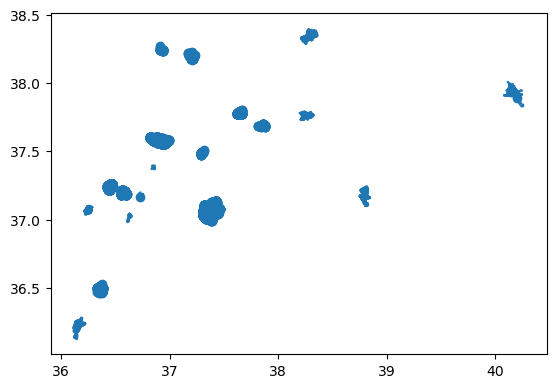

In [71]:
# representation of final dataset
data.plot()
data.head()

/home/lapita/anaconda3/envs/tfm_graph/lib/python3.9/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 24 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


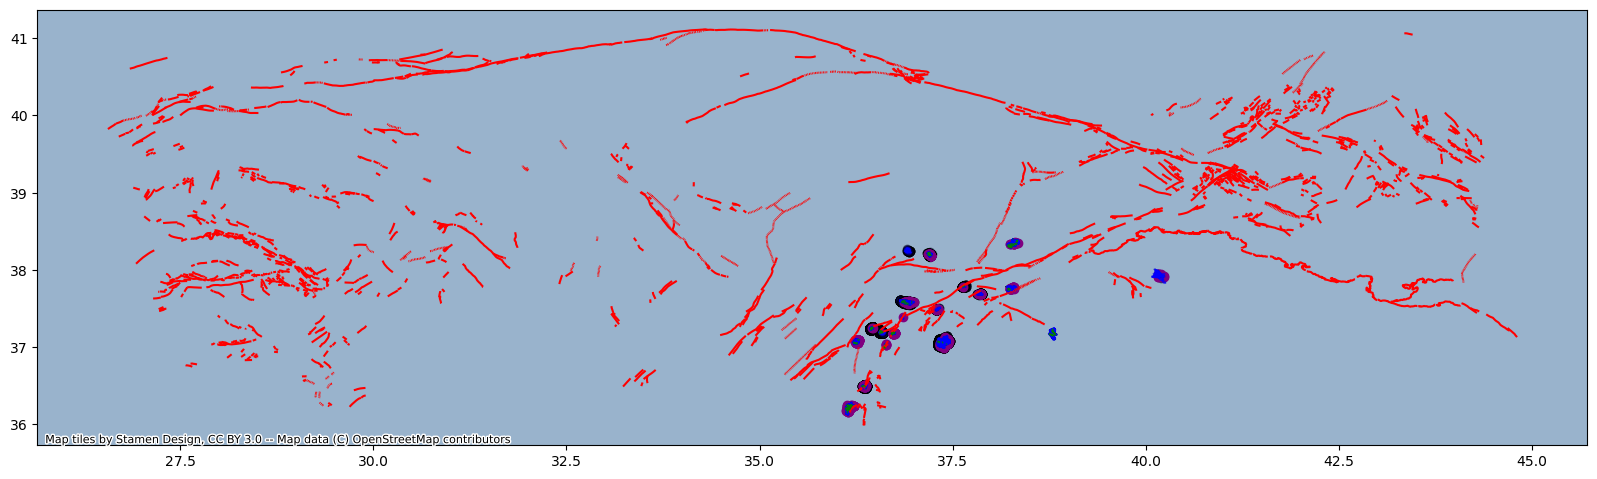

In [81]:
# demonstrating data, faults, water sources and anciliary datas on a base map

# Convert your data to Web Mercator
data = data.to_crs(epsg=4326)
data_faults = data_faults.to_crs(epsg=4326)
data_hidro = data_hidro.to_crs(epsg=4326)
data_anc = data_anc.to_crs(epsg=4326)

# Create a subplot
fig, ax = plt.subplots(figsize=(20, 20))

# Plotting the 'data' GeoDataFrame
data.plot(ax=ax, color='blue', alpha=0.5, edgecolor='k')

# Plotting the 'data_faults' GeoDataFrame
data_faults.plot(ax=ax, color='red')

# Plotting the 'data_hidro' GeoDataFrame
data_hidro.plot(ax=ax, color='green')

# Plotting the 'data_anc' GeoDataFrame
data_anc.plot(ax=ax, color='purple')

# Add a basemap.
ctx.add_basemap(ax)

plt.show()


As can be observed on the map, the indicated buildings are situated near the fault lines, which likely contributed to the damage incurred during the disaster. Concurrently, the data on the fault lines reveal other high-risk areas beyond the zone that was damaged.

    Saving the files for other notebooks:


Now we save the data in the processed folder. Since the data is now large with geometric information, it will be saved both in geojson and pickle format so that we can open in the other notebooks as well.

In [74]:
save_data(data, "dataset")

Data saved as ../data/processed/dataset.geojson and ../data/processed/dataset.pickle
